In [ ]:
import os
import glob
import json
import re
import pandas as pd
from tqdm import tqdm

# ==========================================
# 1. 설정
# ==========================================
DATA_DIR = "/urimalsaem_data"
OUTPUT_FILE = "/urimalsaem_master.csv"

# 필터링 리스트
DROP_LIST = ["옛말", "북한어"]

# ==========================================
# 2. 전처리 함수 (요청 반영: 파이프 절대 안 건드림!)
# ==========================================
def clean_text(text):
    if not isinstance(text, str): return str(text)
    # 1. ^는 띄어쓰기, -는 삭제, ·는 띄어쓰기
    text = text.replace("-", "").replace("^", " ").replace("·", " ")
    return " ".join(text.split())

def clean_relation_word(text):
    if not isinstance(text, str): return str(text)
    text = text.replace("-", "").replace("^", " ").replace("·", " ")
    text = " ".join(text.split())
    # 뒤에 붙은 숫자 제거
    return re.sub(r'\d+$', '', text)

# ==========================================
# 3. 메인 변환 로직
# ==========================================
json_files = glob.glob(os.path.join(DATA_DIR, "*.json"))

if not json_files:
    print("❌ JSON 파일이 없습니다.")
else:
    print(f"📂 총 {len(json_files)}개의 JSON 파일을 처리합니다.")

    all_data = []

    for file_path in tqdm(json_files, desc="JSON 파싱"):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if isinstance(data, dict) and 'channel' in data: items = data['channel']['item']
                elif isinstance(data, list): items = data
                else: items = [data]

                for entry in items:
                    try:
                        # --- 1. 표제어 필터링 ---
                        sense_info = entry.get('senseinfo', {})
                        raw_word_type = sense_info.get('type', '')

                        if any(bad in raw_word_type for bad in DROP_LIST): continue

                        # --- 2. 기본 정보 추출 ---
                        word_info = entry.get('wordinfo', {})
                        raw_word = word_info.get('word', '')
                        target_code = entry.get('target_code')
                        group_code = entry.get('group_code')

                        if not target_code: continue

                        clean_word_val = clean_text(raw_word)
                        my_node_id = f"{clean_word_val}_{target_code}"

                        pos = sense_info.get('pos', '')
                        definition = sense_info.get('definition', '')

                        # 분야 추출
                        cat_list = sense_info.get('cat_info', [])
                        if cat_list:
                            category = cat_list[0].get('cat')
                        else:
                            category = "" # 없으면 빈칸

                        # --- 3. 관계 정보 파싱 ---
                        relations = sense_info.get('relation_info', [])
                        rel_list = []

                        for r in relations:
                            r_type = r.get('type', '')

                            if any(bad in r_type for bad in DROP_LIST): continue

                            r_raw = r.get('word', '')
                            r_code = r.get('link_target_code')

                            if r_code:
                                r_clean = clean_relation_word(r_raw)
                                target_id = f"{r_clean}_{r_code}"
                                rel_list.append(f"{r_type}:{target_id}")

                        # --- 4. 저장 ---
                        all_data.append({
                            "target_code": target_code,
                            "group_code": group_code,
                            "node_id": my_node_id,
                            "word": clean_word_val,
                            "word_type": raw_word_type,
                            "pos": pos,
                            "category": category,
                            "definition": definition,
                            "relations": "|".join(rel_list)
                        })

                    except Exception: continue
        except Exception: continue

    # CSV 저장
    if all_data:
        df_master = pd.DataFrame(all_data)
        print(f"💾 CSV 저장 중... (총 {len(df_master)}행)")
        df_master.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
        print(f"🎉 저장 완료! ({OUTPUT_FILE})")

        # 샘플 확인
        print("\n👀 [데이터 샘플 확인]")
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_colwidth', 100)
        display(df_master.head(5))
    else:
        print("❌ 데이터가 없습니다.")

📂 총 24개의 JSON 파일을 처리합니다.


JSON 파싱: 100%|██████████| 24/24 [01:31<00:00,  3.80s/it]


💾 CSV 저장 중... (총 1115507행)
🎉 저장 완료! (/content/drive/MyDrive/vllm_baseline/urimalsaem_master.csv)

👀 [데이터 샘플 확인]


,target_code,group_code,node_id,word,word_type,pos,category,definition,relations
0,515135,316562,멀쑥이_515135,멀쑥이,일반어,부사,,지저분함이 없이 훤하고 깨끗하게.,
1,518891,316562,멀쑥이_518891,멀쑥이,일반어,부사,,멋없이 키가 크고 생김새가 묽게.,
2,6095,316563,멀쑥하다_6095,멀쑥하다,일반어,형용사,,지저분함이 없이 훤하고 깨끗하다.,참고 어휘:말쑥하다_403958
3,39718,316563,멀쑥하다_39718,멀쑥하다,일반어,형용사,,멋없이 키가 크고 물러 옹골찬 데가 없다.,참고 어휘:말쑥하다_408355
4,596492,316564,멀어지다_596492,멀어지다,일반어,동사,,거리가 많이 떨어지게 되다.,반대말:가까워지다_1709222


In [ ]:
import pandas as pd

# 컬럼 너비 제한을 없앱니다 (None = 무제한)
pd.set_option('display.max_colwidth', None)

# 다시 출력해서 확인

display(df_master[df_master['category']!=''])

,target_code,group_code,node_id,word,word_type,pos,category,definition,relations
8,1633220,1354425,멀어진 지금_1633220,멀어진 지금,일반어,,음악,"박주연 작사, 김형석 작곡의 대중가요. 1996년에 발표된 김혜림의 노래이다.",
9,800953,316567,멀웨어_800953,멀웨어,일반어,명사,정보·통신,"소유자의 승낙 없이 컴퓨터 시스템에 침입하거나 시스템을 손상하기 위해 설계된 소프트웨어. 일단 설치되면 제거하기가 매우 어려우며, 바이러스와 트로이 목마를 포함한다. ⇒규범 표기는 미확정이다.",비슷한말:악성 소프트웨어_805732
59,1015058,316621,멀치_1015058,멀치,일반어,명사,식물,"잡초가 자라거나 땅의 수분이 감소하는 것을 막기 위하여 식물 주위에 뿌리는 짚단, 낙엽, 나무 부스러기 따위의 층. ⇒규범 표기는 미확정이다.",
60,567911,316622,멀칭_567911,멀칭,일반어,명사,농업,"농작물이 자라고 있는 땅을 짚이나 비닐 따위로 덮는 일. 농작물의 뿌리를 보호하고 땅의 온도를 유지하며, 흙의 건조·병충해·잡초 따위를 막을 수 있다.",비슷한말:바닥덮기_159169
61,1110849,316623,멀칭 방법_1110849,멀칭 방법,일반어,,농업,"농작물을 재배할 때, 플라스틱 필름, 짚, 건초, 낙엽, 왕겨, 톱밥 따위로 땅의 표면을 덮어 재배하는 방법. 지온 조절, 토양 수분 조절, 잡초 발생 방지, 병충해 발생 억제 따위의 목적에 따라 피복 재료를 선택할 수 있다.",비슷한말:덮기법_878836|비슷한말:피복법_1025277
...,...,...,...,...,...,...,...,...,...
1115502,839387,499762,생체 유동학_839387,생체 유동학,일반어,,생명,생물체 내에서 분자나 생체액의 흐름과 변형에 관해 연구하는 학문.,비슷한말:생물 유동학_713408
1115503,1082874,499763,생체 응답_1082874,생체 응답,일반어,,생명,"외부로부터 자극을 받게 되면, 생체 내부의 면역력 향상, 항상성 조절 등을 위해 나타나는 몸의 반응.",
1115504,924274,499764,생체 의약품_924274,생체 의약품,일반어,,약학,"항생제, 호르몬제, 백신제, 비타민제 등 생물이 만들어 낸 물질로 구성된 의약품.",비슷한말:생물 의약품_924273
1115505,195245,499765,생체 의용 공학_195245,생체 의용 공학,일반어,,의학,"의학상의 문제에 공학적 방법을 응용하는 일. 심장의 인공 판막(瓣膜), 맹인용(盲人用)의 각종 센서, 자동 의수(義手)·의족(義足) 따위의 보조구의 개발이 대표적인 예이다.",비슷한말:의공학_247712|비슷한말:의술 공학_505385


In [ ]:
df_master[df_master['relations'].str.contains('대역어', na=False)]

,target_code,group_code,node_id,word,word_type,pos,category,definition,relations
8,1633220,1354425,멀어진 지금_1633220,멀어진 지금,일반어,,음악,"박주연 작사, 김형석 작곡의 대중가요. 1996년에 발표된 김혜림의 노래이다.",대역어:멀어진_ORIGIN|대역어:只今_ORIGIN
9,800953,316567,멀웨어_800953,멀웨어,일반어,명사,정보·통신,"소유자의 승낙 없이 컴퓨터 시스템에 침입하거나 시스템을 손상하기 위해 설계된 소프트웨어. 일단 설치되면 제거하기가 매우 어려우며, 바이러스와 트로이 목마를 포함한다. ⇒규범 표기는 미확정이다.",비슷한말:악성 소프트웨어_805732|대역어:malware_ORIGIN
59,1015058,316621,멀치_1015058,멀치,일반어,명사,식물,"잡초가 자라거나 땅의 수분이 감소하는 것을 막기 위하여 식물 주위에 뿌리는 짚단, 낙엽, 나무 부스러기 따위의 층. ⇒규범 표기는 미확정이다.",대역어:mulch_ORIGIN
60,567911,316622,멀칭_567911,멀칭,일반어,명사,농업,"농작물이 자라고 있는 땅을 짚이나 비닐 따위로 덮는 일. 농작물의 뿌리를 보호하고 땅의 온도를 유지하며, 흙의 건조·병충해·잡초 따위를 막을 수 있다.",비슷한말:바닥덮기_159169|대역어:mulching_ORIGIN
61,1110849,316623,멀칭 방법_1110849,멀칭 방법,일반어,,농업,"농작물을 재배할 때, 플라스틱 필름, 짚, 건초, 낙엽, 왕겨, 톱밥 따위로 땅의 표면을 덮어 재배하는 방법. 지온 조절, 토양 수분 조절, 잡초 발생 방지, 병충해 발생 억제 따위의 목적에 따라 피복 재료를 선택할 수 있다.",비슷한말:덮기법_878836|비슷한말:피복법_1025277|대역어:mulching_ORIGIN|대역어:方法_ORIGIN
...,...,...,...,...,...,...,...,...,...
1115502,839387,499762,생체 유동학_839387,생체 유동학,일반어,,생명,생물체 내에서 분자나 생체액의 흐름과 변형에 관해 연구하는 학문.,비슷한말:생물 유동학_713408|대역어:生體流動學_ORIGIN
1115503,1082874,499763,생체 응답_1082874,생체 응답,일반어,,생명,"외부로부터 자극을 받게 되면, 생체 내부의 면역력 향상, 항상성 조절 등을 위해 나타나는 몸의 반응.",대역어:生體應答_ORIGIN
1115504,924274,499764,생체 의약품_924274,생체 의약품,일반어,,약학,"항생제, 호르몬제, 백신제, 비타민제 등 생물이 만들어 낸 물질로 구성된 의약품.",비슷한말:생물 의약품_924273|대역어:生體醫藥品_ORIGIN
1115505,195245,499765,생체 의용 공학_195245,생체 의용 공학,일반어,,의학,"의학상의 문제에 공학적 방법을 응용하는 일. 심장의 인공 판막(瓣膜), 맹인용(盲人用)의 각종 센서, 자동 의수(義手)·의족(義足) 따위의 보조구의 개발이 대표적인 예이다.",비슷한말:의공학_247712|비슷한말:의술 공학_505385|대역어:生體醫用工學_ORIGIN


In [ ]:
import pandas as pd

# 설정된 파일명
OUTPUT_FILE = "/urimalsaem_master2.csv"

# 1. CSV 로드
print(f"📂 파일 읽는 중: {OUTPUT_FILE}")
try:
    df_check = pd.read_csv(OUTPUT_FILE)

    # 2. 출력 설정 (내용 잘리지 않게)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', 100)

    print(f"✅ 데이터 로드 성공! (총 {len(df_check)}건)")

    # 3. 하위 10개 출력
    display(df_check.tail(10))

    # 4. 관계 데이터 샘플 확인 (파이프가 잘 들어갔는지)
    print("\n👀 [관계 데이터 샘플]")
    sample_rel = df_check[df_check['relations'].notna()].iloc[0]['relations']
    print(f"👉 {sample_rel}")

except Exception as e:
    print(f"❌ 파일을 읽을 수 없습니다: {e}")

📂 파일 읽는 중: /content/drive/MyDrive/vllm_baseline/urimalsaem_master2.csv
❌ 파일을 읽을 수 없습니다: [Errno 2] No such file or directory: '/content/drive/MyDrive/vllm_baseline/urimalsaem_master2.csv'


In [ ]:
df_check[df_check['relations'].str.contains('하위어', na=False)].head(10)

,target_code,group_code,node_id,word,pos,category,definition,relations
478,6182,317034,멋_6182,멋,명사,일반어,"차림새, 행동, 됨됨이 따위가 세련되고 아름다움.",하위어:겉멋_339964|하위어:모상_151612|하위어:모양_31546|하위어:야성미_575567|하위어:이국정서_246726|하위어:이국정취_246727|하위어:제멋_4...
479,39784,317034,멋_39784,멋,명사,일반어,고상한 품격이나 운치.,하위어:소치_202144|하위어:취미_411459|하위어:풍재_410520|하위어:풍취_58212|하위어:풍치_410365|상위어:운치_243171|상위어:품격_59142|...
531,347514,317085,멋쟁이_347514,멋쟁이,명사,일반어,멋있거나 멋을 잘 부리는 사람.,비슷한말:모양꾼_568399|하위어:멋장이_151051|상위어:사람_12170|방언:멋재_772994|방언:못쟁이_772995|방언:카다재_772996|방언:카다쟁이_772...
560,531143,317103,멍_531143,멍,명사,일반어,심하게 맞거나 부딪쳐서 살갗 속에 퍼렇게 맺힌 피.,하위어:피멍_27591|상위어:피_401987|방언:심당구_501086|방언:심바우_464370|방언:심장구_464710|방언:밍_568992|방언:싱거무_215740|방언...
644,151282,317174,멍석_151282,멍석,명사,일반어,"짚으로 새끼 날을 만들어 네모지게 결어 만든 큰 깔개. 흔히 곡식을 널어 말리는 데 쓰나, 시골에서는 큰일이 있을 때 마당에 깔아 놓고 손님을 모시기도 했다.",비슷한말:망석_530619|비슷한말:손도점_200373|비슷한말:천석_399550|하위어:덕석_8007|하위어:쇠덕석_199768|하위어:우의_467732|상위어:자리_19...
719,64063,317244,멍울_64063,멍울,명사,일반어,림프샘이나 몸 안의 조직에 병적으로 생기는 둥글둥글한 덩이.,참고 어휘:망울_5930|하위어:가래톳_73697|하위어:쥐_280209|상위어:덩이_368235|방언:말_146730|방언:모드래기_149416|방언:멀_530938|방언...
754,494289,317273,멍청이_494289,멍청이,명사,일반어,아둔하고 어리석은 사람을 놀림조로 이르는 말.,비슷한말:멍텅구리_441465|참고 어휘:비실이_683783|하위어:먹통_457638|상위어:사람_12170|방언:멍치_567686|방언:시레소이_574258|방언:숭물당쥐...
839,494317,317356,메_494317,메,명사,일반어,묵직하고 둥그스름한 나무토막이나 쇠토막에 자루를 박아 무엇을 치거나 박을 때 쓰는 물건.,비슷한말:종규_434110|하위어:떡메_529753|하위어:쇠메_200666|상위어:연장_17140|방언:메겡이_420465|방언:메경이_639752|방언:메뎅이_63975...
1208,531012,317715,메달_531012,메달,명사,일반어,표창이나 기념의 표지로 금·은·동 따위에 여러 가지 모양을 새겨 넣어 만든 둥근 패(牌).,하위어:금_484788|하위어:금메달_452530|하위어:동메달_134073|하위어:은메달_358298|상위어:패_27098
1344,5643,317871,메뚜기_5643,메뚜기,명사,일반어,메뚜깃과의 곤충을 통틀어 이르는 말. 겹눈과 세 개의 홑눈이 있고 뒷다리가 발달하여 잘 뛴다. 불완전 변태를 하며 알로 겨울을 난다.,비슷한말:부종_177814|비슷한말:사종_424606|비슷한말:송서_200652|비슷한말:저계_263304|비슷한말:책맹_287276|비슷한말:청메뚜기_473332|비슷한말...


In [ ]:
print(df_check['category'].unique()[:100])

['일반어' '방언' '옛말' '북한어']


In [ ]:
import os
import glob
import json
from collections import defaultdict

# 1. 설정
DATA_DIR = "urimalsaem_data"

def extract_all_keys(data_list):
    """
    리스트 내 모든 딕셔너리를 뒤져서 존재하는 모든 키 구조를 파악함
    """
    schema_map = defaultdict(set)

    for entry in data_list:
        # 1 Level (wordinfo, senseinfo 등)
        for k1, v1 in entry.items():
            schema_map['root'].add(k1)

            if isinstance(v1, dict):
                # 2 Level (senseinfo 내부 등)
                for k2, v2 in v1.items():
                    schema_map[f'{k1}'].add(k2)

                    # 3 Level (혹시 더 깊숙한 곳에?)
                    if isinstance(v2, dict):
                        for k3, v3 in v2.items():
                            schema_map[f'{k1} > {k2}'].add(k3)
                    elif isinstance(v2, list) and len(v2) > 0 and isinstance(v2[0], dict):
                        # 리스트 안에 딕셔너리가 있는 경우 (예: cat_info)
                        for k3 in v2[0].keys():
                            schema_map[f'{k1} > {k2} (List)'].add(k3)

    return schema_map

# 2. 실행
json_files = glob.glob(os.path.join(DATA_DIR, "*.json"))
target_file = json_files[0] # 파일 하나만 털어도 충분함

print(f"📂 구조 분석 중... ({os.path.basename(target_file)})")

with open(target_file, 'r', encoding='utf-8') as f:
    data = json.load(f)
    if isinstance(data, dict) and 'channel' in data: items = data['channel']['item']
    elif isinstance(data, list): items = data
    else: items = [data]

    # 구조 추출
    schema = extract_all_keys(items)

    print("\n" + "="*50)
    print("🗺️ JSON 전체 구조도 (모든 키 목록)")
    print("="*50)

    # 루트부터 예쁘게 출력
    print(f"[Root Keys]: {sorted(list(schema['root']))}")
    print("-" * 50)

    for parent, children in sorted(schema.items()):
        if parent == 'root': continue
        print(f"📂 [{parent}] 안에 있는 키들:")
        print(f"   👉 {sorted(list(children))}")
        print("-" * 20)

📂 구조 분석 중... (1505285_400000.json)

🗺️ JSON 전체 구조도 (모든 키 목록)
[Root Keys]: ['group_code', 'group_order', 'link', 'senseinfo', 'target_code', 'wordinfo']
--------------------------------------------------
📂 [senseinfo] 안에 있는 키들:
   👉 ['cat_info', 'definition', 'definition_original', 'example_info', 'grammar_info', 'history_info', 'multimedia_info', 'norm_info', 'pattern_info', 'pos', 'proverb_info', 'region_info', 'relation_info', 'scientific_name', 'sense_no', 'sl_info_link', 'translation_info', 'type']
--------------------
📂 [senseinfo > cat_info (List)] 안에 있는 키들:
   👉 ['cat']
--------------------
📂 [senseinfo > example_info (List)] 안에 있는 키들:
   👉 ['example', 'origin', 'region', 'source', 'translation']
--------------------
📂 [senseinfo > grammar_info (List)] 안에 있는 키들:
   👉 ['grammar']
--------------------
📂 [senseinfo > history_info] 안에 있는 키들:
   👉 ['allomorph', 'desc', 'history_sense_info', 'remark', 'word_form']
--------------------
📂 [senseinfo > multimedia_info (List)] 안에 있는 키들:
 

In [ ]:
import os
import glob
import json
from collections import Counter
from tqdm import tqdm

# 1. 설정
DATA_DIR = "/urimalsaem_data"

# 2. 실행
json_files = glob.glob(os.path.join(DATA_DIR, "*.json"))
cat_counter = Counter()

print("🕵️‍♂️ 'cat_info' 내용물 정밀 분석 중...")

for file_path in tqdm(json_files):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if isinstance(data, dict) and 'channel' in data: items = data['channel']['item']
            elif isinstance(data, list): items = data
            else: items = [data]

            for entry in items:
                try:
                    # senseinfo -> cat_info (리스트) -> cat 값 추출
                    sense_info = entry.get('senseinfo', {})
                    cat_info_list = sense_info.get('cat_info', [])

                    # cat_info가 비어있지 않다면 루프 돌면서 수집
                    for cat_item in cat_info_list:
                        cat_val = cat_item.get('cat')
                        if cat_val:
                            cat_counter.update([cat_val])

                except: continue
    except: continue

# 3. 결과 출력
print("\n" + "="*50)
print(f"📊 발견된 'cat' 종류 수: {len(cat_counter)}개")
print("="*50)

# 가장 많이 등장한 상위 100개 출력
print(cat_counter.most_common(100))

🕵️‍♂️ 'cat_info' 내용물 정밀 분석 중...


100%|██████████| 24/24 [01:08<00:00,  2.84s/it]


📊 발견된 'cat' 종류 수: 67개
[('의학', 57006), ('정보·통신', 54569), ('지명', 40199), ('역사', 34964), ('경제', 32911), ('전기·전자', 24040), ('생명', 21796), ('건설', 19396), ('체육', 17451), ('음악', 16809), ('식물', 16572), ('법률', 16263), ('화학', 16212), ('물리', 15222), ('인명', 14244), ('기계', 14123), ('교육', 14107), ('동물', 13380), ('복식', 13370), ('군사', 12955), ('농업', 12899), ('불교', 12368), ('사회 일반', 11294), ('문학', 10094), ('수학', 10091), ('경영', 8725), ('행정', 8468), ('교통', 8430), ('영상', 7543), ('지구', 7322), ('언어', 7281), ('정치', 6842), ('민속', 6608), ('한의', 6385), ('환경', 6051), ('책명', 6044), ('공업', 5821), ('약학', 5803), ('공예', 5788), ('미술', 4973), ('예체능 일반', 4452), ('매체', 4011), ('공학 일반', 3907), ('광업', 3421), ('철학', 3416), ('심리', 3339), ('천문', 3284), ('임업', 2568), ('수의', 2410), ('보건 일반', 2150), ('무용', 2051), ('지리', 2028), ('식품', 1932), ('서비스업', 1879), ('가톨릭', 1723), ('연기', 1697), ('기독교', 1598), ('해양', 1576), ('산업 일반', 1367), ('종교 일반', 1334), ('수산업', 1074), ('자연 일반', 971), ('복지', 869), ('재료', 839), ('천연자원', 723), ('고유명 일반',

In [ ]:
!pip install llama-index-embeddings-huggingface --q

📂 데이터 로드 중... (/content/drive/MyDrive/vllm_baseline/urimalsaem_master.csv)
📏 정의 길이 계산 중...

📊 정의 길이 통계 (글자 수)
count    1115507.000000
mean          50.066720
std           43.760752
min            2.000000
25%           18.000000
50%           37.000000
75%           68.000000
max         1393.000000
Name: len, dtype: object

📈 구간별 분포 (30자 단위)
len_group
0~30       450393
30~60      329615
60~90      161367
90~120      86587
120~150     47139
150~180     23418
180~210      9660
210~240      3794
240~270      1811
270~300       720
300+         1003
Name: count, dtype: int64

📉 구간별 비율 (%)
len_group
0~30       40.38
30~60      29.55
60~90      14.47
90~120      7.76
120~150     4.23
150~180     2.10
180~210     0.87
210~240     0.34
240~270     0.16
270~300     0.06
300+        0.09
Name: count, dtype: float64

😱 가장 긴 정의 TOP 5 (범인 색출)
[52700] 길이: 1393자
내용(앞부분): 어떤 사건 <img style="vertical-align: middle;" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%...
-------------------------

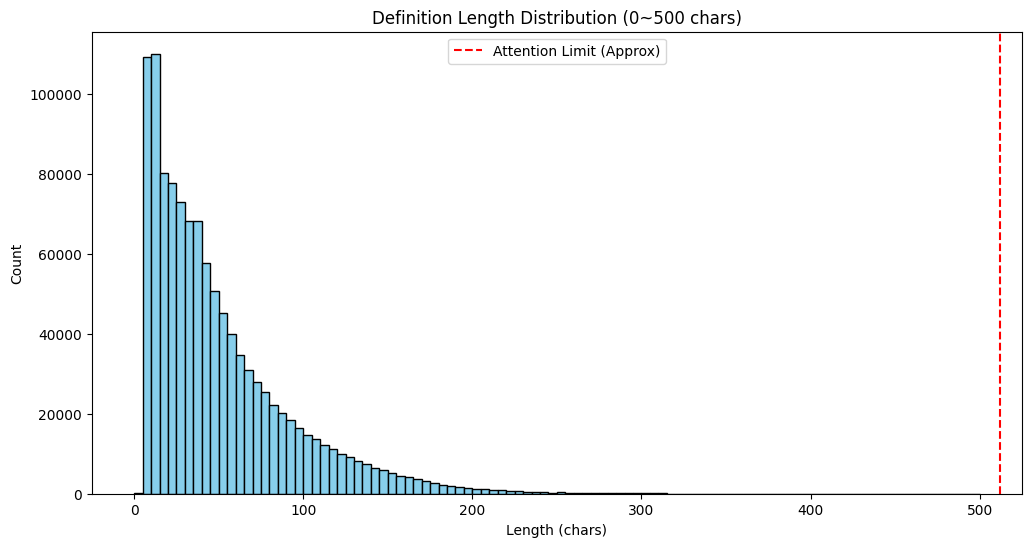

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. CSV 데이터 로드 (필요한 컬럼만 읽어서 속도 향상)
CSV_PATH = "/urimalsaem_master.csv"
print(f"📂 데이터 로드 중... ({CSV_PATH})")

# 'definition' 컬럼만 읽으면 빠릅니다.
df = pd.read_csv(CSV_PATH, usecols=['definition']).fillna("")

# 2. 길이 계산 (글자 수 기준)
print("📏 정의 길이 계산 중...")
df['len'] = df['definition'].apply(len)

# 3. 통계 요약
print("\n" + "="*40)
print("📊 정의 길이 통계 (글자 수)")
print("="*40)
print(df['len'].describe().apply(lambda x: format(x, 'f')))

# 4. 구간별 분포 (30자 단위)
# 0~30, 30~60, ... , 300 이상 (Long tail)
bins = list(range(0, 301, 30))  # 0부터 300까지 30단위
labels = [f"{i}~{i+30}" for i in bins[:-1]]

# 300자 넘는 건 따로 묶기 위해 클리핑
df['len_group'] = pd.cut(df['len'], bins=bins + [np.inf], labels=labels + ['300+'], right=False)

# 분포 계산
dist = df['len_group'].value_counts().sort_index()

print("\n" + "="*40)
print("📈 구간별 분포 (30자 단위)")
print("="*40)
print(dist)

# 비율 보기
print("\n" + "="*40)
print("📉 구간별 비율 (%)")
print("="*40)
print((dist / len(df) * 100).round(2))

# 5. 이상치(Outlier) 확인: 가장 긴 놈들 5개
print("\n" + "="*40)
print("😱 가장 긴 정의 TOP 5 (범인 색출)")
print("="*40)
longest_rows = df.nlargest(5, 'len')
for idx, row in longest_rows.iterrows():
    print(f"[{idx}] 길이: {row['len']}자")
    print(f"내용(앞부분): {row['definition'][:100]}...")
    print("-" * 40)

# 6. 시각화 (히스토그램)
plt.figure(figsize=(12, 6))
plt.hist(df['len'], bins=100, range=(0, 500), color='skyblue', edgecolor='black')
plt.title('Definition Length Distribution (0~500 chars)')
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.axvline(x=512, color='r', linestyle='--', label='Attention Limit (Approx)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# 1. CSV 로드
CSV_PATH = "/urimalsaem_master.csv"
print(f"📂 데이터 로드 중... ({CSV_PATH})")
df = pd.read_csv(CSV_PATH).fillna("")

# 2. 범인 색출 ('<img' 태그가 포함된 정의 찾기)
print("🕵️‍♂️ HTML 이미지 태그가 포함된 정의 검색 중...")

# str.contains로 태그 찾기
dirty_rows = df[df['definition'].str.contains("<img", na=False)]

print(f"\n😱 발견된 오염 데이터: {len(dirty_rows)}개")

# 3. 상세 내용 확인 (상위 5개)
if not dirty_rows.empty:
    print("\n👀 [상세 내용 확인]")
    pd.set_option('display.max_colwidth', None) # 내용 다 보기

    # 단어(word)와 정의(definition)만 뽑아서 출력
    display(dirty_rows[['word', 'definition']].head(5))

    # 아까 사용자님이 본 52700번 인덱스가 있다면 그것도 확인
    if 52700 in df.index:
        print("\n🎯 [제보하신 52700번 데이터]")
        print(f"단어: {df.loc[52700, 'word']}")
        print(f"정의: {df.loc[52700, 'definition']}")

📂 데이터 로드 중... (/content/drive/MyDrive/vllm_baseline/urimalsaem_master.csv)
🕵️‍♂️ HTML 이미지 태그가 포함된 정의 검색 중...

😱 발견된 오염 데이터: 1960개

👀 [상세 내용 확인]


,word,definition
820,메가미터,"미터법에 의한 길이의 단위. 1메가미터는 1미터의 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=10%5E%7B6%7D'>배이다. 기호는 Mm."
1379,메르센의 소수,"<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=2%5E%7Bq-1%7D'> 꼴로 표시되는 소수(素數). 프랑스의 과학 사상가 메르센이 고안하였다."
1388,메르위나이트,"고로 슬래그에서 발견되는 주 결정상의 하나. 화학식은 8CaO, MgO, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=2SiO_%7B2%7D'>로 결정 조직은 단사 정계이며 비중은 3.15이다. ⇒규범 표기는 미확정이다."
1415,메르텐스 추측,"서로 다른 짝수 개수의 소수 곱인 수와, 서로 다른 홀수 개의 소수 곱인 수의 차이는 1 이상의 n에 대해서 결코 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Csqrt%5B%5D%7Bn%7D'>을 넘지 않는다는 추측. 그러나 <FL>오들리즈코</FL>(Odlyzko, A. M.)와 <FL>테 릴레</FL>(te Riele, H.)에 의해 옳지 않음이 증명되었다. ⇒규범 표기는 미확정이다."
2849,메타컴팩트 집합,"유클리드 공간 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=R%5E%7Bn%7D'>의 부분 집합의 모든 점이 유한한 수의 덮개의 원소에만 포함되는 집합. ⇒규범 표기는 미확정이다."



🎯 [제보하신 52700번 데이터]
단어: 결합 확률
정의: 어떤 사건 <img style="vertical-align: middle;" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Cmathit%7Bx%7D'>와 다른 사건 <img style="vertical-align: middle;" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Cmathit%7By%7D'>가 같이 한 조로 되어 발생하는 확률. <img style="vertical-align: middle;" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Cmathit%7BP%28x%7D%2C+%5Cmathit%7By%29%7D'>로 표기하며, 조건부 확률을 <img style="vertical-align: middle;" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Cmathit%7BP%28x%7D%2F%5Cmathit%7By%29%7D'>라 하면 <img style="vertical-align: middle;" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Cmathit%7BP%28x%7D%2C+%5Cmathit%7By%29%3DP%28x%7D%2F%5Cmathit%7By%29P%28y%29%3DP%28y%7D%2F%5Cmathit%7Bx%29P%28x%29%7D'>로 쓸 수 있다. 만약 사건 <img style="vertical-align: middle;" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Cmathit%7Bx%7D'>와 <img style="vertical-align: middle;" src='https://opendic.korean.go.

In [ ]:
import pandas as pd

# 1. CSV 로드
# CSV_PATH = "urimalsaem_master.csv"
print(f"📂 데이터 로드 중...")
df = pd.read_csv(CSV_PATH).fillna("")
original_len = len(df)

print(f"✅ 원본 데이터: {original_len:,}개")

# 2. 관계(Relations)가 있는 것만 필터링! (핵심)
# 빈 문자열("")이거나 NaN이 아닌 것만 남김
df_filtered = df[df['relations'].str.len() > 0].copy()
filtered_len = len(df_filtered)

print("\n" + "="*40)
print(f"🧹 필터링 결과 (관계 없는 단어 삭제)")
print("="*40)
print(f"▶ 남은 데이터: {filtered_len:,}개")
print(f"▶ 삭제된 데이터: {original_len - filtered_len:,}개")
print(f"▶ 감소율: {((original_len - filtered_len) / original_len * 100):.1f}% 삭제됨")

# 3. HTML 태그(<img)가 살아남았는지 확인
dirty_rows = df_filtered[df_filtered['definition'].str.contains("<img", na=False)]
print(f"\n😱 살아남은 오염 데이터(HTML): {len(dirty_rows)}개")

📂 데이터 로드 중...
✅ 원본 데이터: 1,115,507개

🧹 필터링 결과 (관계 없는 단어 삭제)
▶ 남은 데이터: 422,014개
▶ 삭제된 데이터: 693,493개
▶ 감소율: 62.2% 삭제됨

😱 살아남은 오염 데이터(HTML): 679개


In [ ]:
import pandas as pd

# (이전 단계에서 df_filtered가 만들어져 있다고 가정)
# df_filtered = df[df['relations'].str.len() > 0].copy()

# 1. HTML 태그 포함된 행만 추출
dirty_rows = df_filtered[df_filtered['definition'].str.contains("<img", na=False)].copy()

# 2. 길이 계산
dirty_rows['length'] = dirty_rows['definition'].apply(len)

print(f"😱 오염 데이터 개수: {len(dirty_rows)}개")
print("\n" + "="*40)
print("📊 오염 데이터 길이 통계")
print("="*40)
print(dirty_rows['length'].describe())

# 3. 가장 긴 놈 5개 (악질 범인 확인)
print("\n" + "="*40)
print("🤮 가장 긴 정의 TOP 5 (내용 확인)")
print("="*40)
pd.set_option('display.max_colwidth', None)
display(dirty_rows[['word', 'length', 'definition']].sort_values(by='length', ascending=False).head(5))

# 4. 랜덤 샘플 5개 (평균적인 놈들 확인)
print("\n" + "="*40)
print("🎲 랜덤 샘플 5개")
print("="*40)
display(dirty_rows[['word', 'definition']].sample(min(5, len(dirty_rows))))

😱 오염 데이터 개수: 679개

📊 오염 데이터 길이 통계
count    679.00000
mean     287.17673
std      145.34011
min      120.00000
25%      201.00000
50%      227.00000
75%      335.00000
max      962.00000
Name: length, dtype: float64

🤮 가장 긴 정의 TOP 5 (내용 확인)


,word,length,definition
342211,선형계,962,"중첩의 원리가 성립하는 시스템. <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=x_%7B1%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=y_%7B1%7D'>이고 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=x_%7B2%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=y_%7B2%7D'>일 때, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28x_%7B1%7D%5Cplus+x_%7B2%7D%29'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28y_%7B1%7D%5Cplus+y_%7B2%7D%29'>이고, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=kx_%7B1%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=ky_%7B1%7D'>이 되는 성질을 가지고 있다."
342317,선형 시스템,962,"중첩의 원리가 성립하는 시스템. <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=x_%7B1%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=y_%7B1%7D'>이고 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=x_%7B2%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=y_%7B2%7D'>일 때, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28x_%7B1%7D%5Cplus+x_%7B2%7D%29'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28y_%7B1%7D%5Cplus+y_%7B2%7D%29'>이고, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=kx_%7B1%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=ky_%7B1%7D'>이 되는 성질을 가지고 있다."
931805,광전 문턱,860,"광전 효과를 일으키는 진동수<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28v_%7B0%7D%29'>의 한계. 전자를 해방시키는 데 필요한 최소 에너지를 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=E_%7B0%7D'>, 빛의 진동수를 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=v'>, 플랑크 상수를 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=h'>라 할 때, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28hv+-+e_%7B0%7D%29'>가 광전자의 운동 에너지 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=E_%7B0%7D+%3D+hN_%7B0%7D'>에서 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=v_%7B0%7D'> 이상 진동수의 빛 흡수로 광전 효과가 일어난다."
223660,비감소열,754,"<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=k'>가 자연수일 때, 집합열 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7B1%7D'>,<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7B2%7D'>,<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7B3%7D'>,……가 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7Bk%7D'><img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Csubset'><img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7Bk%2B1%7D'>을 만족하는 열."
231712,비증가열,754,"<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=k'>가 자연수일 때, 집합열 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7B1%7D'>,<img style=""vertical-align: middle;"" src='https://opendic.kore


🎲 랜덤 샘플 5개


,word,definition
501583,시클로헥탄,"탄소 원자 백 개가 차례로 연결된 고리형 구조를 가지는 화합물. 탄소와 연결되지 않은 나머지는 수소 원자로 연결되어 있다. 화학식은 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=C_%7B100%7DH_%7B200%7D'>. ⇒규범 표기는 미확정이다."
258956,하이퍼블릭 코사인 함수,"지수 함수로 표현되는 <FL>하이퍼볼릭 함수</FL> 가운데 하나. <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Cfrac%7Be%5E%7Bx%7D%2Be%5E%7B-x%7D%7D%7B2%7D'>로 표현된다. ⇒규범 표기는 미확정이다."
1084967,사이클로테트라콘텐,"탄소 원자 사십 개가 차례로 연결되어 있고 그 사이에 탄소와 탄소의 이중 결합이 있는 고리형 구조 화합물. 탄소와 연결되지 않은 나머지는 수소 원자로 연결되어 있다. 화학식은 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=C_%7B40%7DH_%7B78%7D'>. ⇒규범 표기는 미확정이다."
90621,과압,"폭발 때, 폭풍의 순간적 압력 따위와 같이 대기압을 훨씬 웃도는 압력. 단위는 1b/<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=in%5E%7B2%7D'> 또는 파스칼(Pa)."
121582,웅성 불임성,"꽃가루, 꽃밥, 수술의 생식 기관에 결함이 있어 수정이 이루어지지 않는 현상. 주로 꽃가루 결함에 의한 불임으로 화분이 생성되지 않거나 기능을 상실한 화분이 생성된다. 웅성 불임을 이용하면 일대 교잡종(<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=F_%7B1%7D'>)을 경제적으로 채종할 수 있다."


In [ ]:
import pandas as pd
import re
import numpy as np

# 1. CSV 로드
# CSV_PATH = "urimalsaem_master.csv"
print(f"📂 데이터 로드 중... ({CSV_PATH})")
df = pd.read_csv(CSV_PATH).fillna("")

# ==========================================
# 2. 전처리 시뮬레이션 (HTML 제거)
# ==========================================
def remove_html_tags(text):
    if not isinstance(text, str): return str(text)
    # <...> 형태의 태그를 공백으로 치환하고, 다중 공백 정리
    clean = re.sub(r'<[^>]+>', ' ', text)
    return " ".join(clean.split())

print("🧹 HTML 태그 청소 중...")
# 원본과 비교하기 위해 새로운 컬럼 생성
df['clean_def'] = df['definition'].apply(remove_html_tags)
df['new_len'] = df['clean_def'].apply(len)

# ==========================================
# 3. 결과 분석
# ==========================================

# (1) 길이 통계 비교
print("\n" + "="*40)
print("📊 청소 전 vs 후 길이 통계 (글자 수)")
print("="*40)
print(f"전: Max {df['definition'].apply(len).max()}자 / Mean {df['definition'].apply(len).mean():.1f}자")
print(f"후: Max {df['new_len'].max()}자      / Mean {df['new_len'].mean():.1f}자")

# (2) 여전히 긴 놈들 확인 (Top 10)
print("\n" + "="*40)
print("🧐 청소 후에도 여전히 긴 정의 TOP 10")
print("   -> (혹시 이상한 찌꺼기가 남았나 확인하세요)")
print("="*40)

pd.set_option('display.max_colwidth', None)
longest_rows = df.nlargest(10, 'new_len')[['word', 'new_len', 'clean_def', 'definition']]
display(longest_rows)

# (3) 혹시 덜 지워진 태그가 있나? ('<' 문자가 아직도 있는지 체크)
leftover_tags = df[df['clean_def'].str.contains("<", na=False)]
if not leftover_tags.empty:
    print(f"\n⚠️ 주의: 아직도 '<' 기호가 포함된 데이터가 {len(leftover_tags)}개 있습니다.")
    display(leftover_tags[['word', 'clean_def']].head(3))
else:
    print("\n✅ '<' 기호가 완전히 사라졌습니다. 태그 박멸 성공!")

📂 데이터 로드 중... (/content/drive/MyDrive/vllm_baseline/urimalsaem_master.csv)
🧹 HTML 태그 청소 중...

📊 청소 전 vs 후 길이 통계 (글자 수)
전: Max 1393자 / Mean 50.1자
후: Max 551자      / Mean 49.4자

🧐 청소 후에도 여전히 긴 정의 TOP 10
   -> (혹시 이상한 찌꺼기가 남았나 확인하세요)


,word,new_len,clean_def,definition
932563,광포 전설,551,"돌부처상에 붉은 물감을 칠한 불경한 인물 때문에 해일이 일어나서 착한 노인 한 사람을 제외한 마을 사람들이 모두 목숨을 잃는다는 내용의 설화. 대표적인 함몰 설화의 하나로, 함경남도 정평군 선덕면 광포라는 지명을 쓰고 있다. 거지 차림의 도승이 자신에게 음식을 대접한 가난한 노인에게 뒷산의 돌부처에서 피눈물이 나면 피난을 가라고 일러 준다. 이 노인은 매일 돌부처를 살폈는데, 어느 날 동네의 나쁜 사람이 이 돌부처에 붉은 물감을 칠하여 피가 흐르는 것처럼 하였다. 그러자 갑자기 해일이 일어나서, 돌부처에서 피눈물이 난 줄 알고 피난을 간 착한 노인만 살고 마을 사람들이 모두 죽었다. 이러한 전설은 경상북도 안동시 길안면 대곡리의 영감 바위, 전라북도 군산 앞바다의 고군산 열도, 전라북도 부안군 계회도의 유래담이다. 이 전설은 한국뿐 아니라 중국과 일본에도 비슷한 내용으로 전해지고 있다. 중국에는 전한 시대부터 역양호(歷陽湖) 함몰 전설이 있었는데, 이것이 우리나라에 전해졌다는 견해가 있다. 일본에는 비슷한 내용의 포도 전설(捕島傳說)이 있는데, 한국에서 전래되었다고 한다.","돌부처상에 붉은 물감을 칠한 불경한 인물 때문에 해일이 일어나서 착한 노인 한 사람을 제외한 마을 사람들이 모두 목숨을 잃는다는 내용의 설화. 대표적인 함몰 설화의 하나로, 함경남도 정평군 선덕면 광포라는 지명을 쓰고 있다. 거지 차림의 도승이 자신에게 음식을 대접한 가난한 노인에게 뒷산의 돌부처에서 피눈물이 나면 피난을 가라고 일러 준다. 이 노인은 매일 돌부처를 살폈는데, 어느 날 동네의 나쁜 사람이 이 돌부처에 붉은 물감을 칠하여 피가 흐르는 것처럼 하였다. 그러자 갑자기 해일이 일어나서, 돌부처에서 피눈물이 난 줄 알고 피난을 간 착한 노인만 살고 마을 사람들이 모두 죽었다. 이러한 전설은 경상북도 안동시 길안면 대곡리의 영감 바위, 전라북도 군산 앞바다의 고군산 열도, 전라북도 부안군 계회도의 유래담이다. 이 전설은 한국뿐 아니라 중국과 일본에도 비슷한 내용으로 전해지고 있다. 중국에는 전한 시대부터 역양호(歷陽湖) 함몰 전설이 있었는데, 이것이 우리나라에 전해졌다는 견해가 있다. 일본에는 비슷한 내용의 포도 전설(捕島傳說)이 있는데, 한국에서 전래되었다고 한다."
351813,세법 적용의 원칙,545,"해석에 의하여 규범적 의미가 명확해진 세법의 규정을 과세 관청이나 납세자가 조사·검토·확인에 의하여 인정한 요건 사실에 결부시키는 세법 적용의 작용에서 지켜야 하는 원칙. 첫째, 세법의 해석이나 적용에서 과세의 형평과 해당 조항의 합목적성에 비추어 납세자의 재산권이 부당히 침해되지 아니하도록 하여야 하고, 둘째, 국세를 납부할 의무가 성립한 소득·수익·재산·행위 또는 거래에 대하여는 그 성립 후의 새로운 세법에 의하여 소급 과세 하지 아니해야 하며, 세법의 해석이나 국세 행정의 관행이 일반적으로 납세자에게 받아들여진 후에는 새로운 해석이나 관행에 의하여 소급 과세 되지 아니하여야 하고, 셋째, 세무 공무원이 그 재량에 의하여 직무를 수행할 때에 과세의 형평과 세법의 목적에 비추어 일반적으로 적당하다고 인정되는 한계를 엄수해야 하며, 넷째, 세법에 특별한 규정이 있는 경우를 제외하고는 과세 표준을 조사하고 결정할 때 해당 납세 의무자가 계속 적용하고 있는 기업 회계의 기준 또는 관행으로서 일반적으로 공정하거나 타당하다고 인정되는 것은 이를 존중해야 한다는 것이다.","해석에 의하여 규범적 의미가 명확해진 세법의 규정을 과세 관청이나 납세자가 조사·검토·확인에 의하여 인정한 요건 사실에 결부시키는 세법 적용의 작용에서 지켜야 하는 원칙. 첫째, 세법의 해석이나 적용에서 과세의 형평과 해당 조항의 합목적성에 비추어 납세자의 재산권이 부당히 침해되지 아니하도록 하여야 하고, 둘째, 국세를 납부할 의무가 성립한 소득·수익·재산·행위 또는 거래에 대하여는 그 성립 후의 새로운 세법에 의하여 소급 과세 하지 아니해야 하며, 세법의 해석이나 국세 행정의 관행이 일반적으로 납세자에게 받아들여진 후에는 새로운 해석이나 관행에 의하여 소급 과세 되지 아니하여야 하고, 셋째, 세무 공무원이 그 재량에 의하여 직무를 수행할 때에 과세의 형평과 세법의 목적에 비추어 일반적으로 적당하다고 인정되는 한계를 엄수해야 하며, 넷째, 세법에 특별한 규정이 있는 경우를 제외하고는 과세 표준을 조사하고 결정할 때 해당 납세 의무자가 계속 적용하고 있는 기업 회계의 기준 또는 관행으로서 일반적으로 공정하거나 타당하다고 인정되는 것은 이를 존중해야 한다는 것이다."
815833,감염증 정기 보고 제도,540,"일본 약사법 제68조 8의 제1항에 규정된 법령으로 시행되는 것으로, 생물 유래 제품에 의하여 발생하는 감염증에 대한 정기 보고 제도. 우리나라에서도 약사법에 따라, 의약품 따위로 인한 부작용 및 품목 허가 정보, 품목 신고 정보 등 의약품의 안전과 관련한 각종 정보의 수집·관리·분석·평가·제공 업무를 효율적이고 체계적으로 수행하기 위하여 한국 의약품 안전 관리원을 설립하였다. 또한 의약품 따위의 제조업자, 품목 허가를 받은 자, 수입자와 의약품 도매상은 의약품 따위로 말미암아 발생하였다고 의심되는 유해 사례로서 질병·장애·사망, 그 밖에 국무총리령으로 정하는 의약품의 안전성과 유효성에 관한 사례를 알게 된 경우에는 식품 의약품 안전처장이 정하는 바에 따라 의약품 안전 관리원장에게 보고하도록 하고 있다. 더불어 약국 개설자와 의료 기관 개설자는 의약품 따위로 말미암아 발생하였다고 의심되는 유해 사례로서 국무총리령으로 정하는 중대한 질병·장애·사망 사례를 알게 된 경우에는 식품 의약품 안전처장이 정하는 바에 따라 의약품 안전 관리원장에게 보고하여야 한다.","일본 약사법 제68조 8의 제1항에 규정된 법령으로 시행되는 것으로, 생물 유래 제품에 의하여 발생하는 감염증에 대한 정기 보고 제도. 우리나라에서도 약사법에 따라, 의약품 따위로 인한 부작용 및 품목 허가 정보, 품목 신고 정보 등 의약품의 안전과 관련한 각종 정보의 수집·관리·분석·평가·제공 업무를 효율적이고 체계적으로 수행하기 위하여 한국 의약품 안전 관리원을 설립하였다. 또한 의약품 따위의 제조업자, 품목 허가를 받은 자, 수입자와 의약품 도매상은 의약품 따위로 말미암아 발생하였다고 의심되는 유해 사례로서 질병·장애·사망, 그 밖에 국무총리령으로 정하는 의약품의 안전성과 유효성에 관한 사례를 알게 된 경우에는 식품 의약품 안전처장이 정하는 바에 따라 의약품 안전 관리원장에게 보고하도록 하고 있다. 더불어 약국 개설자와 의료 기관 개설자는 의약품 따위로 말미암아 발생하였다고 의심되는 유해 사례로서 국무총리령으로 정하는 중대한 질병·장애·사망 사례를 알게 된 경우에는 식품 의약품 안전처장이 정하는 바에 따라 의약품 안전 관리원장에게 보고하여야 한다."
567176,육십갑자병납음,535,"육십갑자를 5음에 분배하여, 1율이 5음을 가지게 하고 12율을 60음에 배정하여 늘어놓은 것. 갑자 을축 해중금(海中金), 병인 정묘 노중화(爐中火), 무진 기사 대림목(大林木), 경오 신미 노방토(路傍土), 임신 계유 검봉금(劒鋒金), 갑술 을해 산두화(山頭火), 병자 정축 간하수(澗下水), 무인 기묘 성두토(城頭土), 경진 신사 백랍금(白鑞金), 임오 계미 양류목(楊柳木), 갑신 을유 정중수(井中水), 병술 정해 옥상토(屋上土), 무자 기축 벽력화(霹靂火), 경인 신묘 송백목(松柏木), 임진 계사 장류수(長流水), 갑오 을미 사중금(沙中金), 병신 정유 산하화(山下火), 무술 기해 평지목(平地木), 경자 신축 벽상토(壁上土), 임인 계묘 금박금(金箔金), 갑진 을사 복등화(覆燈火), 병오 정미 천하수(天河水), 무신 기유 대역토(大驛土), 경술 신해 차천금(釵釧金), 임자 계축 상백목(桑柏木), 갑인 을묘 대계수(大溪水), 병진 정사 사중토(沙中土), 무오 기미 천상화(天上火), 경신 신유 석류목(石榴木), 임술 계해 대해수(大海水)이다.","육십갑자를 5음에 분배하여, 1율이 5음을 가지게 하고 12율을 60음에 배정하여 늘어놓은 것. 갑


⚠️ 주의: 아직도 '<' 기호가 포함된 데이터가 7개 있습니다.


,word,clean_def
256896,하마르티아,비극에서 주인공을 파멸에 이르게 만드는 주인공 자신의 선천적인 결함이나 성격. 아리스토텔레스가 <시학에서 처음 사용한 말이다. ⇒규범 표기는 미확정이다.
297665,눈송이 왈츠,<호두까기 인형＞에서 눈 내리는 풍경 속에 클라라와 왕자가 떠나는 모습을 그리는 작품에 사용된 왈츠.
375131,수렴 반경,주어진 멱급수가 수렴하는 범위. 중심이 a인 멱급수에 대하여 |x-a|<R를 만족하는 x는 항상 수렴하도록 잡은 R 중에서 가장 큰 값이다.


In [ ]:
import pandas as pd
import re
import numpy as np

# 1. 설정
INPUT_PATH = "urimalsaem_master.csv"
FILTERED_OUTPUT_PATH = "urimalsaem_filtered.csv"

print(f"📂 원본 데이터 로드 중... ({INPUT_PATH})")
df = pd.read_csv(INPUT_PATH).fillna("")
print(f"✅ 원본 개수: {len(df):,}개")

# ======================================================
# 1. 관계가 있는 애들만 CSV로 만들기
# ======================================================
print("\n🧹 [Step 1] 관계(Relations) 없는 데이터 삭제 중...")

# relations 컬럼에 내용이 있는 것만 필터링
# (공백 제거 후 길이가 0보다 큰 것)
df_filtered = df[df['relations'].str.strip().str.len() > 0].copy()

print(f"💾 필터링된 CSV 저장 중... ({FILTERED_OUTPUT_PATH})")
df_filtered.to_csv(FILTERED_OUTPUT_PATH, index=False, encoding='utf-8-sig')

print(f"✅ 필터링 완료: {len(df_filtered):,}개 (생존율: {len(df_filtered)/len(df)*100:.1f}%)")

# ======================================================
# 2. 클렌징 적용 전: 가장 긴 문장 5개, 평균 길이
# ======================================================
print("\n" + "="*60)
print("🔍 [Step 2] 클렌징 전(Original) 데이터 분석")
print("="*60)

# 길이 계산
df_filtered['len_orig'] = df_filtered['definition'].apply(len)
avg_len_orig = df_filtered['len_orig'].mean()

print(f"📊 평균 정의 길이: {avg_len_orig:.2f} 자")

print("\n😱 [Top 5] 가장 긴 정의 (원본)")
pd.set_option('display.max_colwidth', None) # 전체 내용 보기
display(df_filtered.nlargest(5, 'len_orig')[['word', 'len_orig', 'definition']])

# ======================================================
# 3. 클렌징 적용 후: 가장 짧은 3개, 긴 3개, 평균 길이
# ======================================================
def full_clean_text(text):
    if not isinstance(text, str): return str(text)

    # 1. HTML 태그 제거
    text = re.sub(r'<[^>]+>', ' ', text)

    # 2. 기호 제거 (-, ^, ·, |)
    text = text.replace("-", "").replace("^", " ").replace("·", " ").replace("|", "")

    # 3. 다중 공백 정리
    return " ".join(text.split())

print("\n" + "="*60)
print("✨ [Step 3] 클렌징 후(Cleaned) 데이터 분석")
print("="*60)

# 전처리 적용
df_filtered['clean_def'] = df_filtered['definition'].apply(full_clean_text)
df_filtered['len_clean'] = df_filtered['clean_def'].apply(len)

avg_len_clean = df_filtered['len_clean'].mean()
print(f"📊 평균 정의 길이: {avg_len_clean:.2f} 자 (변화: {avg_len_orig:.2f} -> {avg_len_clean:.2f})")

print("\n📉 [Bottom 3] 가장 짧은 정의 (혹시 빈칸이 되었나 확인)")
display(df_filtered.nsmallest(3, 'len_clean')[['word', 'len_clean', 'clean_def']])

print("\n📈 [Top 3] 가장 긴 정의 (여전히 너무 긴지 확인)")
display(df_filtered.nlargest(3, 'len_clean')[['word', 'len_clean', 'clean_def']])

📂 원본 데이터 로드 중... (/content/drive/MyDrive/vllm_baseline/urimalsaem_master.csv)
✅ 원본 개수: 1,115,507개

🧹 [Step 1] 관계(Relations) 없는 데이터 삭제 중...
💾 필터링된 CSV 저장 중... (/content/drive/MyDrive/vllm_baseline/urimalsaem_filtered.csv)
✅ 필터링 완료: 422,014개 (생존율: 37.8%)

🔍 [Step 2] 클렌징 전(Original) 데이터 분석
📊 평균 정의 길이: 54.43 자

😱 [Top 5] 가장 긴 정의 (원본)


,word,len_orig,definition
342211,선형계,962,"중첩의 원리가 성립하는 시스템. <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=x_%7B1%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=y_%7B1%7D'>이고 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=x_%7B2%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=y_%7B2%7D'>일 때, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28x_%7B1%7D%5Cplus+x_%7B2%7D%29'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28y_%7B1%7D%5Cplus+y_%7B2%7D%29'>이고, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=kx_%7B1%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=ky_%7B1%7D'>이 되는 성질을 가지고 있다."
342317,선형 시스템,962,"중첩의 원리가 성립하는 시스템. <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=x_%7B1%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=y_%7B1%7D'>이고 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=x_%7B2%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=y_%7B2%7D'>일 때, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28x_%7B1%7D%5Cplus+x_%7B2%7D%29'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28y_%7B1%7D%5Cplus+y_%7B2%7D%29'>이고, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=kx_%7B1%7D'>에 대한 응답이 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=ky_%7B1%7D'>이 되는 성질을 가지고 있다."
931805,광전 문턱,860,"광전 효과를 일으키는 진동수<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28v_%7B0%7D%29'>의 한계. 전자를 해방시키는 데 필요한 최소 에너지를 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=E_%7B0%7D'>, 빛의 진동수를 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=v'>, 플랑크 상수를 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=h'>라 할 때, <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%28hv+-+e_%7B0%7D%29'>가 광전자의 운동 에너지 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=E_%7B0%7D+%3D+hN_%7B0%7D'>에서 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=v_%7B0%7D'> 이상 진동수의 빛 흡수로 광전 효과가 일어난다."
223660,비감소열,754,"<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=k'>가 자연수일 때, 집합열 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7B1%7D'>,<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7B2%7D'>,<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7B3%7D'>,……가 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7Bk%7D'><img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=%5Csubset'><img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7Bk%2B1%7D'>을 만족하는 열."
231712,비증가열,754,"<img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=k'>가 자연수일 때, 집합열 <img style=""vertical-align: middle;"" src='https://opendic.korean.go.kr/JSP/formula.jsp?latex=A_%7B1%7D'>,<img style=""vertical-align: middle;"" src='https://opendic.ko


✨ [Step 3] 클렌징 후(Cleaned) 데이터 분석
📊 평균 정의 길이: 53.81 자 (변화: 54.43 -> 53.81)

📉 [Bottom 3] 가장 짧은 정의 (혹시 빈칸이 되었나 확인)


,word,len_clean,clean_def
403181,조켓버릇,3,조카뻘
4237,며칠,4,몇 날.
34479,뭉칫돈,4,큰 돈.



📈 [Top 3] 가장 긴 정의 (여전히 너무 긴지 확인)


,word,len_clean,clean_def
932563,광포 전설,551,"돌부처상에 붉은 물감을 칠한 불경한 인물 때문에 해일이 일어나서 착한 노인 한 사람을 제외한 마을 사람들이 모두 목숨을 잃는다는 내용의 설화. 대표적인 함몰 설화의 하나로, 함경남도 정평군 선덕면 광포라는 지명을 쓰고 있다. 거지 차림의 도승이 자신에게 음식을 대접한 가난한 노인에게 뒷산의 돌부처에서 피눈물이 나면 피난을 가라고 일러 준다. 이 노인은 매일 돌부처를 살폈는데, 어느 날 동네의 나쁜 사람이 이 돌부처에 붉은 물감을 칠하여 피가 흐르는 것처럼 하였다. 그러자 갑자기 해일이 일어나서, 돌부처에서 피눈물이 난 줄 알고 피난을 간 착한 노인만 살고 마을 사람들이 모두 죽었다. 이러한 전설은 경상북도 안동시 길안면 대곡리의 영감 바위, 전라북도 군산 앞바다의 고군산 열도, 전라북도 부안군 계회도의 유래담이다. 이 전설은 한국뿐 아니라 중국과 일본에도 비슷한 내용으로 전해지고 있다. 중국에는 전한 시대부터 역양호(歷陽湖) 함몰 전설이 있었는데, 이것이 우리나라에 전해졌다는 견해가 있다. 일본에는 비슷한 내용의 포도 전설(捕島傳說)이 있는데, 한국에서 전래되었다고 한다."
1041571,장자못 설화,500,"장자의 인색함 때문에 그의 집이 물벼락을 맞아 연못이 되었다는 이야기. 함몰 설화 가운데 하나이다. 옛날 어느 마을에 마음씨 고약한 부자 영감 장자가 살고 있었다. 하루는 장자가 자기 집 외양간에서 쇠똥을 치우고 있는데 어떤 중이 와서 시주를 청했다. 인색한 장자는 그 중의 바랑에 쇠똥을 퍼 주었다. 부엌에서 그 광경을 본 며느리가 놀라 뒤꼍에서 몰래 중을 불러 쌀을 퍼 주며 시아버지의 무례함을 용서해 달라고 빌었다. 그러자 중은 며느리에게 빨리 집을 나와 자기를 따라오되 어떤 경우에도 절대로 뒤를 돌아보지 말라고 당부하였다. 며느리가 집을 나서 중의 뒤를 쫓아가다가 산 중턱에 이르렀을 때 갑자기 등 뒤에서 뇌성벽력이 치는 소리가 들렸다. 놀란 며느리는 집에 두고 온 빨래, 뚜껑을 덮지 않은 장독, 베틀 따위가 생각나서 뒤를 돌아보았고 그 순간 그 자리에서 돌로 변해 버렸다. 장자의 집은 큰 연못으로 변해 버렸는데 요즈음도 비가 오는 날이면 그 속에서 다듬이질 소리가 들린다고 한다."
1041572,장자못 전설,500,"장자의 인색함 때문에 그의 집이 물벼락을 맞아 연못이 되었다는 이야기. 함몰 설화 가운데 하나이다. 옛날 어느 마을에 마음씨 고약한 부자 영감 장자가 살고 있었다. 하루는 장자가 자기 집 외양간에서 쇠똥을 치우고 있는데 어떤 중이 와서 시주를 청했다. 인색한 장자는 그 중의 바랑에 쇠똥을 퍼 주었다. 부엌에서 그 광경을 본 며느리가 놀라 뒤꼍에서 몰래 중을 불러 쌀을 퍼 주며 시아버지의 무례함을 용서해 달라고 빌었다. 그러자 중은 며느리에게 빨리 집을 나와 자기를 따라오되 어떤 경우에도 절대로 뒤를 돌아보지 말라고 당부하였다. 며느리가 집을 나서 중의 뒤를 쫓아가다가 산 중턱에 이르렀을 때 갑자기 등 뒤에서 뇌성벽력이 치는 소리가 들렸다. 놀란 며느리는 집에 두고 온 빨래, 뚜껑을 덮지 않은 장독, 베틀 따위가 생각나서 뒤를 돌아보았고 그 순간 그 자리에서 돌로 변해 버렸다. 장자의 집은 큰 연못으로 변해 버렸는데 요즈음도 비가 오는 날이면 그 속에서 다듬이질 소리가 들린다고 한다."


In [ ]:
display(df_filtered.head(5))

,target_code,group_code,node_id,word,word_type,pos,category,definition,relations,len_orig,clean_def,len_clean
2,6095,316563,멀쑥하다_6095,멀쑥하다,일반어,형용사,,지저분함이 없이 훤하고 깨끗하다.,참고 어휘:말쑥하다_403958,18,지저분함이 없이 훤하고 깨끗하다.,18
3,39718,316563,멀쑥하다_39718,멀쑥하다,일반어,형용사,,멋없이 키가 크고 물러 옹골찬 데가 없다.,참고 어휘:말쑥하다_408355,23,멋없이 키가 크고 물러 옹골찬 데가 없다.,23
4,596492,316564,멀어지다_596492,멀어지다,일반어,동사,,거리가 많이 떨어지게 되다.,반대말:가까워지다_1709222,15,거리가 많이 떨어지게 되다.,15
5,596493,316564,멀어지다_596493,멀어지다,일반어,동사,,어떤 기준점에 모자라게 되다.,반대말:가까워지다_1709225,16,어떤 기준점에 모자라게 되다.,16
6,596495,316564,멀어지다_596495,멀어지다,일반어,동사,,서로의 사이가 다정하거나 가깝지 않고 서먹서먹하게 되다.,반대말:가까워지다_1709224|반대말:가까워지다_1709226,31,서로의 사이가 다정하거나 가깝지 않고 서먹서먹하게 되다.,31


In [ ]:
!pip install llama-index-embeddings-huggingface --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 148.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
import pandas as pd
import networkx as nx
import pickle
import re
import gc
import torch
from tqdm.notebook import tqdm
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# ==========================================
# 1. 설정 (파일명 변경!)
# ==========================================
# 🚨 입력: 필터링된 CSV (42만 개)
CSV_PATH = "urimalsaem_filtered.csv"
# 🚨 출력: 이름 변경 (덮어쓰기 방지)
SAVE_PATH = "urimalsaem_graph_FINAL.pkl"

MODEL_ID = "BAAI/bge-m3"
EMBED_BATCH_SIZE = 1024     # A100 풀파워
SUPER_BATCH_SIZE = 40000   # 데이터 줄었으니 10만 개씩

# 가중치
RELATION_WEIGHTS = {
    "동의어": 0.95, "준말": 0.9, "본말": 0.9,
    "비슷한말": 0.7, "방언": 0.6,
    "관련어": 0.5, "참고 어휘": 0.4,
    "하위어": 0.2
}

# ==========================================
# 2. 헬퍼 함수
# ==========================================
def remove_html_tags(text):
    if not isinstance(text, str): return str(text)
    clean = re.sub(r'<[^>]+>', ' ', text)
    return " ".join(clean.split())

# ==========================================
# 3. 메인 빌드 함수
# ==========================================
def build_graph_rerun():
    print(f"🔥 [Re-Run] 지식 그래프 재구축 시작")
    print(f"   -> 타겟 파일: {SAVE_PATH}")

    # 1. 모델 로드
    print(f"🧠 임베딩 모델 로드 중... ({MODEL_ID})")
    embed_model = HuggingFaceEmbedding(
        model_name=MODEL_ID,
        device="cuda",
        embed_batch_size=EMBED_BATCH_SIZE,
        trust_remote_code=True
    )

    # 2. 데이터 로드
    print(f"📂 CSV 로드 중... ({CSV_PATH})")
    df = pd.read_csv(CSV_PATH).fillna("")
    print(f"✅ 데이터 개수: {len(df):,}개")

    # 3. HTML 청소
    print("🧹 정의 텍스트 HTML 태그 청소 중...")
    df['definition'] = df['definition'].apply(remove_html_tags)

    G = nx.Graph()
    nodes_to_embed = []

    # 4. 그래프 구조 구축
    print("🕸️ 그래프 구조 연결 중...")
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Building Graph", mininterval=0.5):
        node_id = str(row['node_id'])
        word = str(row['word'])
        definition = str(row['definition'])

        G.add_node(
            node_id,
            word=word,
            pos=row['pos'],
            category=row['category'],
            definition=definition,
            target_code=row['target_code']
        )

        if definition.strip():
            text_to_embed = f"{word}: {definition}"
            nodes_to_embed.append((node_id, text_to_embed))

        relations_str = str(row['relations'])
        if relations_str:
            for item in relations_str.split("|"):
                if ":" in item:
                    try:
                        r_type, target_id = item.rsplit(":", 1)
                        weight = RELATION_WEIGHTS.get(r_type.strip(), 0.0)
                        if weight > 0:
                            G.add_edge(node_id, target_id.strip(), relation=r_type.strip(), weight=weight)
                    except: continue

    print(f"✅ 그래프 뼈대 완성! (Nodes: {G.number_of_nodes():,}, Edges: {G.number_of_edges():,})")

    # 5. 임베딩 (10만 개씩)
    print(f"🚀 정의 {len(nodes_to_embed):,}개 임베딩 시작...")

    target_ids = [x[0] for x in nodes_to_embed]
    target_texts = [x[1] for x in nodes_to_embed]

    if target_texts:
        try:
            for i in tqdm(range(0, len(target_texts), SUPER_BATCH_SIZE), desc="Embedding Chunks"):
                chunk_ids = target_ids[i : i + SUPER_BATCH_SIZE]
                chunk_texts = target_texts[i : i + SUPER_BATCH_SIZE]

                embeddings = embed_model.get_text_embedding_batch(
                    chunk_texts, show_progress=True
                )

                for nid, vec in zip(chunk_ids, embeddings):
                    if nid in G:
                        G.nodes[nid]['vector'] = vec

                del embeddings
                gc.collect()
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"❌ 임베딩 실패: {e}")

    # 6. 저장
    print(f"💾 피클 저장 중... ({SAVE_PATH})")
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(G, f)

    print("🎉 [재구축 완료] 이번엔 진짜입니다!")
    return G

# 실행
if __name__ == "__main__":
    KG = build_graph_rerun()

🔥 [Re-Run] 지식 그래프 재구축 시작
   -> 타겟 파일: /content/drive/MyDrive/vllm_baseline/urimalsaem_graph_FINAL.pkl
🧠 임베딩 모델 로드 중... (BAAI/bge-m3)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


📂 CSV 로드 중... (/content/drive/MyDrive/vllm_baseline/urimalsaem_filtered.csv)
✅ 데이터 개수: 422,014개
🧹 정의 텍스트 HTML 태그 청소 중...
🕸️ 그래프 구조 연결 중...


Building Graph:   0%|          | 0/422014 [00:00<?, ?it/s]

✅ 그래프 뼈대 완성! (Nodes: 520,473, Edges: 656,188)
🚀 정의 422,014개 임베딩 시작...


Embedding Chunks:   0%|          | 0/11 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/40000 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/22014 [00:00<?, ?it/s]

💾 피클 저장 중... (/content/drive/MyDrive/vllm_baseline/urimalsaem_graph_FINAL.pkl)
🎉 [재구축 완료] 이번엔 진짜입니다!


In [ ]:
import pickle
import networkx as nx
import random
import numpy as np

# 1. 파일 로드
# (방금 저장한 경로와 동일해야 합니다)
PKL_PATH = "/content/drive/MyDrive/vllm_baseline/urimalsaem_graph_FINAL.pkl"

print(f"📂 그래프 파일 로드 중... ({PKL_PATH})")

try:
    with open(PKL_PATH, 'rb') as f:
        G = pickle.load(f)

    print("✅ 로드 성공!")
    print(f"   - 총 노드 수: {G.number_of_nodes():,}")
    print(f"   - 총 엣지 수: {G.number_of_edges():,}")

    # 2. 랜덤 10개 노드 상세 조회
    print("\n" + "="*60)
    print("🧐 [랜덤 10개 노드 상세 검사]")
    print("="*60)

    all_nodes = list(G.nodes())
    sample_nodes = random.sample(all_nodes, 10)

    for i, node_id in enumerate(sample_nodes):
        # 노드 속성 가져오기
        attrs = G.nodes[node_id]

        print(f"[{i+1}] 노드 ID: {node_id}")
        print(f"   🔹 단어: {attrs.get('word', 'N/A')}")
        print(f"   🔹 품사: {attrs.get('pos', 'N/A')}")
        print(f"   🔹 분야: {attrs.get('category', 'N/A')}")
        print(f"   🔹 정의: {attrs.get('definition', 'N/A')[:50]}...") # 너무 길면 자름

        # 벡터 확인
        if 'vector' in attrs:
            vec = attrs['vector']
            # 벡터가 있으면 차원수 출력 (예: 1024차원)
            print(f"   🧠 벡터: 있음 (Shape: {np.shape(vec)})")
            # print(f"   🧠 벡터(일부): {vec[:5]}...") # 값 보고 싶으면 주석 해제
        else:
            print(f"   ❌ 벡터: 없음 (정의가 비어있거나 누락됨)")

        # 연결된 이웃(Edge) 확인
        neighbors = list(G.neighbors(node_id))
        if neighbors:
            # 이웃 중 3개만 예시로 출력
            nb_summary = []
            for nb in neighbors[:3]:
                edge_data = G.get_edge_data(node_id, nb)
                rel = edge_data.get('relation', '?')
                w = edge_data.get('weight', 0.0)
                # 이웃의 단어 정보도 가져오기 (ID에서 추출하거나 그래프에서 조회)
                nb_word = G.nodes[nb].get('word', nb.split('_')[0])
                nb_summary.append(f"{nb_word}({rel}, {w})")

            print(f"   🔗 관계({len(neighbors)}개): {', '.join(nb_summary)} ...")
        else:
            print("   🔗 관계: 없음 (고립된 노드)")

        print("-" * 60)

except Exception as e:
    print(f"❌ 파일 읽기 실패: {e}")

📂 그래프 파일 로드 중... (/content/drive/MyDrive/vllm_baseline/urimalsaem_graph_FINAL.pkl)
✅ 로드 성공!
   - 총 노드 수: 520,473
   - 총 엣지 수: 656,188

🧐 [랜덤 10개 노드 상세 검사]
[1] 노드 ID: 그두쟁이_685835
   🔹 단어: N/A
   🔹 품사: N/A
   🔹 분야: N/A
   🔹 정의: N/A...
   ❌ 벡터: 없음 (정의가 비어있거나 누락됨)
   🔗 관계(1개): 톱장이(방언, 0.6) ...
------------------------------------------------------------
[2] 노드 ID: 장지수지_261083
   🔹 단어: 장지수지
   🔹 품사: 명사
   🔹 분야: 
   🔹 정의: 예전에, 곤장으로 때린 뒤에 다시 옥에 가둠을 이르던 말....
   🧠 벡터: 있음 (Shape: (1024,))
   🔗 관계(1개): 장수(비슷한말, 0.7) ...
------------------------------------------------------------
[3] 노드 ID: 간데온데없다_339103
   🔹 단어: 간데온데없다
   🔹 품사: 형용사
   🔹 분야: 
   🔹 정의: 감쪽같이 자취를 감추어 찾을 수가 없다....
   🧠 벡터: 있음 (Shape: (1024,))
   🔗 관계(1개): 온데간데없다(비슷한말, 0.7) ...
------------------------------------------------------------
[4] 노드 ID: 동적 임시 스위치 간 신호 처리_823344
   🔹 단어: 동적 임시 스위치 간 신호 처리
   🔹 품사: 
   🔹 분야: 정보·통신
   🔹 정의: 에이티엠 네트워크에서, 링크 실패 시 자동으로 연결을 라우팅 하는 임시 스위치 간 신호 처...
   🧠 벡터: 있음 (Shape: (1024,))
   🔗 관계(1개): 다이내믹 아

In [ ]:
import pickle

# 1. 코랩 로컬 경로에 저장 (드라이브 아님!)
LOCAL_PATH = "/content/drive/MyDrive/vllm_baseline/urimalsaem_graph_FINAL2.pkl"

print("💾 코랩 로컬 디스크에 저장 중...")
with open(LOCAL_PATH, 'wb') as f:
    pickle.dump(G, f)

print(f"✅ 저장 완료! 경로: {LOCAL_PATH}")

💾 코랩 로컬 디스크에 저장 중...
✅ 저장 완료! 경로: /content/drive/MyDrive/vllm_baseline/urimalsaem_graph_FINAL2.pkl


In [ ]:
from huggingface_hub import HfApi, login

# 1. 내 아이디와 올릴 레포지토리 이름 설정
# 본인 허깅페이스 아이디로 바꿔주세요 (로그인되어 있으면 자동 인식되기도 함)
REPO_ID = ""
HF_TOKEN = ""
# 2. 로그인 다시 수행
login(token=HF_TOKEN)

# 3. API 초기화 (여기에도 토큰 전달)
api = HfApi(token=HF_TOKEN)
# 2. 레포지토리 생성 (없으면 생성, 있으면 패스)
try:
    api.create_repo(repo_id=REPO_ID, repo_type="dataset", private=True)
    print(f"✅ 레포지토리 생성 완료: https://huggingface.co/datasets/{REPO_ID}")
except:
    print("ℹ️ 레포지토리가 이미 존재합니다. 여기에 덮어씁니다.")

# 3. 파일 업로드 (고속 업로드 지원)
print("🚀 허깅페이스로 업로드 시작 (브라우저 다운보다 훨씬 빠름)...")
api.upload_file(
    path_or_fileobj="urimalsaem_graph_FINAL.pkl",
    path_in_repo="urimalsaem_graph_FINAL.pkl",
    repo_id=REPO_ID,
    repo_type="dataset"
)

print("🎉 업로드 성공! 허깅페이스 사이트에서 다운로드하세요.")

✅ 레포지토리 생성 완료: https://huggingface.co/datasets/hyos0415/urimalsaem-graph-bge-vector
🚀 허깅페이스로 업로드 시작 (브라우저 다운보다 훨씬 빠름)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...rimalsaem_graph_FINAL.pkl:   0%|          |  761kB / 4.02GB            

🎉 업로드 성공! 허깅페이스 사이트에서 다운로드하세요.


In [ ]:
import re
import pickle
from tqdm.notebook import tqdm

# 1. 로드된 그래프 (G)가 있다고 가정합니다.
# (만약 없다면 다시 pickle load 하세요)
if 'G' not in locals():
    with open("/urimalsaem_vector_graph.pkl", 'rb') as f:
        G = pickle.load(f)

print("🧹 그래프 내부 텍스트 청소 시작 (벡터는 유지)...")

# 2. 태그 제거 함수
def quick_clean(text):
    if not isinstance(text, str): return text
    # <FL>, <sup...>, <img> 등 꺽쇠로 묶인 모든 태그 삭제
    return re.sub(r'<[^>]+>', '', text)

# 3. 노드 순회하며 정의(definition) 수정
count = 0
for node_id in tqdm(G.nodes()):
    raw_def = G.nodes[node_id].get('definition', '')

    if raw_def and '<' in raw_def: # 태그가 있는 것만 건드림
        clean_def = quick_clean(raw_def)

        # 수정된 정의로 덮어쓰기
        G.nodes[node_id]['definition'] = clean_def
        count += 1

print(f"✅ 총 {count:,}개의 노드에서 태그를 제거했습니다!")

# 4. 다시 저장 (덮어쓰기)
SAVE_PATH = "urimalsaem_vector_graph.pkl"
with open(SAVE_PATH, 'wb') as f:
    pickle.dump(G, f)

print("💾 깨끗해진 그래프 저장 완료!")

🧹 그래프 내부 텍스트 청소 시작 (벡터는 유지)...


  0%|          | 0/1121602 [00:00<?, ?it/s]

✅ 총 32,156개의 노드에서 태그를 제거했습니다!
💾 깨끗해진 그래프 저장 완료!


In [ ]:
import networkx as nx

def find_nodes(graph, keyword, mode="exact", limit=10):
    """
    그래프에서 단어(keyword)를 검색합니다.
    - mode="exact": 정확히 일치하는 단어만 검색 (예: '배' -> '배'만 나옴)
    - mode="contains": 포함하는 단어 검색 (예: '배' -> '배', '서양배', '배나무' 등)
    """
    print(f"🔎 검색어: '{keyword}' (모드: {mode}) 검색 중...")

    found_nodes = []

    # 전체 노드 순회 (데이터가 많아도 메모리상이라 꽤 빠릅니다)
    for node_id, attrs in graph.nodes(data=True):
        word = attrs.get('word', '')

        # 조건 검사
        if mode == "exact":
            if word == keyword:
                found_nodes.append((node_id, attrs))
        elif mode == "contains":
            if keyword in word:
                found_nodes.append((node_id, attrs))

    if not found_nodes:
        print("❌ 검색 결과가 없습니다.")
        return

    print(f"✅ 총 {len(found_nodes)}개의 노드를 찾았습니다. (상위 {limit}개 출력)\n")

    # 결과 출력
    for i, (node_id, attrs) in enumerate(found_nodes[:limit]):
        print(f"[{i+1}] ID: {node_id}")
        print(f"   🔹 단어: {attrs.get('word')}")
        print(f"   🔹 분야: {attrs.get('category', 'N/A')}")
        print(f"   🔹 정의: {attrs.get('definition', '')[:60]}...") # 길면 자름

        # 이웃(관계) 확인
        neighbors = list(graph.neighbors(node_id))
        if neighbors:
            nb_list = []
            for nb in neighbors[:5]: # 이웃 최대 5개만 표시
                edge = graph.get_edge_data(node_id, nb)
                rel = edge.get('relation', '?')
                # 이웃 단어 이름 가져오기
                nb_word = graph.nodes[nb].get('word', nb.split('_')[0])
                nb_list.append(f"{nb_word}({rel})")

            print(f"   🔗 관계: {', '.join(nb_list)}")
            if len(neighbors) > 5:
                print(f"      ... 외 {len(neighbors)-5}개 더 있음")
        else:
            print("   🔗 관계: 없음 (고립된 노드)")

        print("-" * 60)

# ==========================================
# 실행 예시
# ==========================================
# (가정) G 변수에 그래프가 로드되어 있어야 합니다.

# 1. 정확히 '배' 찾기 (동음이의어들이 다 나와야 함)
find_nodes(G, "배", mode="exact")

# 2. '사인'이 포함된 단어 찾기 (아까 태그 제거 잘 됐는지 확인용)
find_nodes(G, "하이퍼블릭 아크 사인", mode="contains")

🔎 검색어: '배' (모드: exact) 검색 중...
✅ 총 27개의 노드를 찾았습니다. (상위 10개 출력)

[1] ID: 배_622336
   🔹 단어: 배
   🔹 분야: 
   🔹 정의: ‘바’의 방언...
   🔗 관계: 바(방언), 바(방언), 바(방언), 바(방언)
------------------------------------------------------------
[2] ID: 배_10308
   🔹 단어: 배
   🔹 분야: 
   🔹 정의: 어떤 수나 양을 두 번 합한 만큼....
   🔗 관계: 곱(비슷한말), 곱절(비슷한말), 수량(하위어), 갑절(비슷한말), 멩이(방언)
------------------------------------------------------------
[3] ID: 배_42074
   🔹 단어: 배
   🔹 분야: 
   🔹 정의: 일정한 수나 양이 그만큼 거듭됨을 이르는 말....
   🔗 관계: 곱(비슷한말), 곱절(비슷한말), 가배(하위어), 배가(하위어), 멩이(방언)
------------------------------------------------------------
[4] ID: 배_167958
   🔹 단어: 배
   🔹 분야: 
   🔹 정의: 배나무의 열매....
   🔗 관계: 과일(하위어), 이자(비슷한말), 생리(비슷한말)
------------------------------------------------------------
[5] ID: 배_772783
   🔹 단어: 배
   🔹 분야: 
   🔹 정의: ‘켤레’의 방언...
   🔗 관계: 켤레(방언)
------------------------------------------------------------
[6] ID: 배_1060177
   🔹 단어: 배
   🔹 분야: 수의
   🔹 정의: 등쪽 면과 배쪽 면을 가진 동물체에서, 등쪽과 반대로 앞면이나 지면을 향하는 부위....
   🔗 관계: 복(비슷한말

In [ ]:
# G가 메모리에 있다고 가정
sample_node_id = list(G.nodes()) # 첫 번째 노드 ID 가져오기
attrs = G.nodes[sample_node_id]     # 속성 딕셔너리 가져오기

print(f"📌 노드 ID: {sample_node_id}")
print(f"🔑 속성 키(Key) 목록: {list(attrs.keys())}")
print("-" * 30)
# 내용물 살짝 보기
for k, v in attrs.items():
    # 벡터는 너무 기니까 모양(Shape)만 출력
    if k == 'vector':
        print(f" - {k}: Vector Shape {getattr(v, 'shape', 'Unknown')}")
    else:
        print(f" - {k}: {str(v)[:50]}...")

📌 노드 ID: 물둥구릿과_158164
🔑 속성 키(Key) 목록: ['word', 'pos', 'category', 'definition', 'target_code']
------------------------------
 - word: 물둥구릿과...
 - pos: 명사...
 - category: 동물...
 - definition: 곤충강 노린재목의 한 과. 앞다리는 벌레를 잡아먹기에 알맞고 가운뎃다리, 뒷다리는 헤엄치기...
 - target_code: 158164...


In [ ]:
target_id = "하이퍼블릭 아크 사인 함수_1186705"

# 1. 노드 정보 가져오기 (딕셔너리 형태)
if target_id in G:
    node_data = G.nodes[target_id]

    print(f"🎯 [노드 조회 성공] {target_id}")
    print("-" * 50)

    # 속성 하나씩 예쁘게 출력
    for key, value in node_data.items():
        if key == 'vector':
            print(f"🧠 vector: {value.shape} (너무 길어서 생략)")
        else:
            print(f"🔹 {key}: {value}")

    print("-" * 50)

    # 2. 연결된 이웃(관계)도 같이 보기
    print("🔗 [연결된 관계]")
    for neighbor in G.neighbors(target_id):
        edge_data = G.get_edge_data(target_id, neighbor)
        rel = edge_data.get('relation', '?')
        weight = edge_data.get('weight', 0.0)
        print(f"   -> {neighbor} ({rel}, {weight})")

else:
    print("❌ 해당 ID를 가진 노드가 그래프에 없습니다.")

🎯 [노드 조회 성공] 하이퍼블릭 아크 사인 함수_1186705
--------------------------------------------------
🔹 word: 하이퍼블릭 아크 사인 함수
🔹 pos: 
🔹 category: 수학
🔹 definition: 하이퍼볼릭 함수 가운데 하나. 하이퍼볼릭 사인의 역함수이다. ⇒규범 표기는 미확정이다.
🔹 target_code: 1186705
--------------------------------------------------
🔗 [연결된 관계]
   -> 하이퍼볼릭 아크 사인_1187971 (비슷한말, 0.7)
   -> 하이퍼볼릭 아크 사인 함수_1142543 (비슷한말, 0.7)
   -> 하이퍼볼릭 역사인_1142587 (비슷한말, 0.7)
   -> 하이퍼블릭 아크 사인_1142551 (비슷한말, 0.7)
   -> 쌍곡 아크 사인 함수_1142662 (비슷한말, 0.7)
   -> 아크 쌍곡 사인 함수_1142653 (비슷한말, 0.7)
   -> 아크 하이퍼볼릭 사인_1142536 (비슷한말, 0.7)
   -> 역쌍곡 사인 함수_1142647 (비슷한말, 0.7)
   -> 역하이퍼볼릭 사인 함수_1142628 (비슷한말, 0.7)


In [ ]:
from collections import Counter
import numpy as np

print("📊 [그래프 속성 정밀 분석 시작]")

attr_counter = Counter()
total_nodes = G.number_of_nodes()
sample_values = {}

# 전체 노드 순회
for _, attrs in G.nodes(data=True):
    # 1. 키 카운팅 (어떤 속성이 몇 개나 있나)
    attr_counter.update(attrs.keys())

    # 2. 샘플 값 수집 (각 키별로 어떤 값이 들어있나 눈으로 확인용)
    for k, v in attrs.items():
        if k not in sample_values:
            if k == 'vector':
                sample_values[k] = f"[Vector] Shape: {np.shape(v)}"
            else:
                sample_values[k] = str(v)[:30] + "..."

print(f"✅ 전체 노드 수: {total_nodes:,}개\n")
print(f"{'속성명(Key)':<15} | {'채워진 노드 수':<15} | {'비율(%)':<10} | {'샘플 데이터'}")
print("-" * 80)

for key, count in attr_counter.most_common():
    ratio = (count / total_nodes) * 100
    sample = sample_values.get(key, "")
    print(f"{key:<15} | {count:<15,} | {ratio:<10.1f}% | {sample}")

📊 [그래프 속성 정밀 분석 시작]
✅ 전체 노드 수: 1,121,602개

속성명(Key)        | 채워진 노드 수        | 비율(%)      | 샘플 데이터
--------------------------------------------------------------------------------
word            | 1,115,475       | 99.5      % | 멀쑥이...
pos             | 1,115,475       | 99.5      % | 부사...
category        | 1,115,475       | 99.5      % | ...
definition      | 1,115,475       | 99.5      % | 지저분함이 없이 훤하고 깨끗하게....
target_code     | 1,115,475       | 99.5      % | 515135...


In [ ]:
# 사용법: !unzip "압축파일경로" -d "압축풀폴더경로"

# 예시 (경로를 님 파일에 맞게 수정하세요!)
!unzip "/content/drive/MyDrive/vllm_baseline/전체 내려받기_우리말샘_json_20251103.zip" -d "/content/drive/MyDrive/vllm_baseline/urimalsaem_data"

Archive:  /content/drive/MyDrive/vllm_baseline/전체 내려받기_우리말샘_json_20251103.zip
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_100000.json  
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_400000.json  
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_800000.json  
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_1050000.json  
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_500000.json  
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_1150000.json  
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_600000.json  
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_250000.json  
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_950000.json  
  inflating: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_700000.json  
  inflating: /content/driv

In [ ]:
df1 = pd.read_json('/content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_100000.json')

In [ ]:
import glob
import os

# 압축 푼 폴더 경로 (아까 unzip 코드의 extract_path)
folder_path = "/content/drive/MyDrive/vllm_baseline/urimalsaem_data" # <-- 본인 경로로 수정!

# json으로 끝나는 파일 다 찾기
json_files = glob.glob(f"{folder_path}/**/*.json", recursive=True)

print(f"🔎 발견된 JSON 파일: {len(json_files)}개")

for i, f in enumerate(json_files[:5]): # 5개만 보여줌
    print(f"[{i}] {f}")

# 첫 번째 파일을 타겟으로 설정
if json_files:
    target_file = json_files[0]
    print(f"\n🎯 분석할 파일: {target_file}")
else:
    print("❌ JSON 파일을 못 찾았어요. 폴더 경로를 확인해보세요!")

🔎 발견된 JSON 파일: 24개
[0] /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_100000.json
[1] /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_400000.json
[2] /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_800000.json
[3] /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_1050000.json
[4] /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_500000.json

🎯 분석할 파일: /content/drive/MyDrive/vllm_baseline/urimalsaem_data/1505285_100000.json


In [ ]:
# 위에서 찾은 target_file 경로 사용
if 'target_file' in locals():
    print(f"📂 파일: {os.path.basename(target_file)}")
    print("-" * 30)

    with open(target_file, 'r', encoding='utf-8') as f:
        # 딱 500글자만 읽어서 출력 (메모리 안전)
        head_text = f.read(2000)
        print(head_text)
        print("...")

📂 파일: 1505285_100000.json
------------------------------
{
  "channel": {
    "total": 50000,
    "title": "사전 검색",
    "description": "사전 검색 결과",
    "item": [
      {
        "wordinfo": {
          "conju_info": [
            {
              "conjugation_info": {
                "pronunciation_info": {
                  "pronunciation": "걷낀만"
                },
                "conjugation": "겉깃만"
              }
            }
          ],
          "pronunciation_info": [
            {
              "pronunciation": "걷낃"
            }
          ],
          "word_unit": "어휘",
          "word": "겉-깃",
          "word_type": "고유어"
        },
        "group_order": 1,
        "group_code": 45783,
        "link": "http://opendict.korean.go.kr/dictionary/view?sense_no=83812",
        "target_code": 83812,
        "senseinfo": {
          "definition": "겉으로 드러난 옷깃.",
          "relation_info": [
            {
              "link": "http://opendict.korean.go.kr/dictionary/view?sense_no=42

In [ ]:
import json
import pprint # 예쁘게 출력해주는 도구

def inspect_json(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            # 1. 일단 로드 (파일이 수백 MB가 넘어가면 이 방법 말고 ijson 써야 함)
            # 우리말샘 낱권 파일은 보통 크지 않으니 로드해도 됩니다.
            data = json.load(f)

            sample_item = None

            # 2. 구조에 따라 샘플 추출
            if isinstance(data, list):
                print(f"Type: 리스트 (총 {len(data)}개 아이템)")
                sample_item = data[0]
            elif isinstance(data, dict):
                print(f"Type: 딕셔너리 (최상위 키: {list(data.keys())})")

                # 우리말샘 구조상 보통 channel -> item 안에 데이터가 있음
                if 'channel' in data and 'item' in data['channel']:
                    items = data['channel']['item']
                    print(f" -> channel -> item 발견! (총 {len(items)}개)")
                    sample_item = items[0]
                else:
                    # 그냥 첫 번째 키의 값을 샘플로
                    first_key = list(data.keys())[0]
                    sample_item = data[first_key]

            # 3. 샘플 출력
            print("\n=== [데이터 샘플 1개] ===")
            pprint.pprint(sample_item, indent=2, compact=False)

    except Exception as e:
        print(f"읽기 실패: {e}")

# 실행
if 'target_file' in locals():
    inspect_json(target_file)

Type: 딕셔너리 (최상위 키: ['channel'])
 -> channel -> item 발견! (총 50000개)

=== [데이터 샘플 1개] ===
{ 'group_code': 45783,
  'group_order': 1,
  'link': 'http://opendict.korean.go.kr/dictionary/view?sense_no=83812',
  'senseinfo': { 'definition': '겉으로 드러난 옷깃.',
                 'definition_original': '겉으로 드러난 옷깃.',
                 'example_info': [ { 'example': '깃에는 {겉깃} 길이, 안깃 길이, 뒷깃, 깃 나비가 '
                                                '다른데, 그것이 섶에 이르면 더욱 복잡하다.',
                                     'source': '최명희, 혼불'}],
                 'pos': '명사',
                 'relation_info': [ { 'link': 'http://opendict.korean.go.kr/dictionary/view?sense_no=428156',
                                      'link_target_code': 428156,
                                      'type': '반대말',
                                      'word': '안-깃001'},
                                    { 'link': 'http://opendict.korean.go.kr/dictionary/view?sense_no=369385',
                                      'link_target_c

In [ ]:
import json
import glob

# JSON 파일 경로 (아까 그 경로)
json_folder = "/content/drive/MyDrive/vllm_baseline/urimalsaem_data"
json_files = glob.glob(f"{json_folder}/**/*.json", recursive=True)

# 중복 없이 타입만 저장할 집합(Set)
unique_types = set()

print(f"📂 {len(json_files)}개의 파일을 스캔하여 관계 타입을 수집합니다...")

count = 0
for file_path in json_files:
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            items = data.get('channel', {}).get('item', [])

            for item in items:
                relations = item.get('senseinfo', {}).get('relation_info', [])
                for rel in relations:
                    # 'type' 필드 값 수집 (예: 비슷한말, 반대말...)
                    if 'type' in rel:
                        unique_types.add(rel['type'])

    except Exception:
        pass # 에러 나면 그냥 패스

    count += 1
    # 너무 오래 걸리면 50개 파일만 보고 멈추셔도 됩니다.
    if count >= 50:
        print("   (속도를 위해 50개 파일만 샘플링했습니다)")
        break

print("-" * 30)
print("🔎 발견된 관계 타입 목록:")
for t in sorted(list(unique_types)):
    print(f"- {t}")

📂 24개의 파일을 스캔하여 관계 타입을 수집합니다...
------------------------------
🔎 발견된 관계 타입 목록:
- 낮춤말
- 높임말
- 반대말
- 방언
- 본말
- 비슷한말
- 상위어
- 옛말
- 준말
- 참고 어휘
- 하위어


In [ ]:
import json
import glob
import re
import csv
import os

# =========================================================
# 1. 설정
# =========================================================
JSON_FOLDER = "/content/drive/MyDrive/vllm_baseline/urimalsaem_data/" # 데이터 폴더 경로
OUTPUT_CSV = "urimalsaem_import.csv"      # 생성될 CSV 파일명

# 관계별 가중치 (GraphRAG에서 중요!)
RELATION_WEIGHTS = {
    "동의어": 1.0,
    "준말": 1.0,
    "본말": 1.0,
    "비슷한말": 0.8,
    "방언": 0.9,
    "상위어": 0.2,
    "하위어": 0.2
}

# =========================================================
# 2. 텍스트 청소 함수
# =========================================================
def clean_text(text):
    if not text: return ""
    text = re.sub(r'\d+$', '', text) # 숫자 제거
    text = text.replace("-", "").replace("^", "").strip()
    return text

# =========================================================
# 3. CSV 생성 로직
# =========================================================
def json_to_csv_for_neo4j():
    json_files = glob.glob(f"{JSON_FOLDER}/**/*.json", recursive=True)
    print(f"📂 총 {len(json_files)}개 파일 변환 시작...")

    # CSV 파일 열기 (쓰기 모드)
    with open(OUTPUT_CSV, 'w', newline='', encoding='utf-8') as csvfile:
        # 헤더 정의 (Neo4j가 좋아할 이름들)
        fieldnames = ['source', 'target', 'relation', 'weight']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        count = 0
        row_count = 0

        for file_path in json_files:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    items = data.get('channel', {}).get('item', [])

                    for item in items:
                        # 중심 단어 (출발 노드)
                        raw_head = item.get('wordinfo', {}).get('word', '')
                        source = clean_text(raw_head)

                        if not source: continue

                        # 관계 정보 (도착 노드)
                        relations = item.get('senseinfo', {}).get('relation_info', [])

                        for rel in relations:
                            rel_type = rel.get('type')
                            target_raw = rel.get('word')

                            # 우리가 정의한 관계만 CSV에 기록
                            if rel_type in RELATION_WEIGHTS and target_raw:
                                target = clean_text(target_raw)
                                if not target: continue

                                # CSV 한 줄 쓰기
                                writer.writerow({
                                    'source': source,
                                    'target': target,
                                    'relation': rel_type,
                                    'weight': RELATION_WEIGHTS[rel_type]
                                })
                                row_count += 1

            except Exception:
                continue

            count += 1
            if count % 1000 == 0:
                print(f"Running... {count}파일 처리 완료 ({row_count}개 관계 생성)")

    print("-" * 30)
    print(f"✅ CSV 생성 완료! 파일명: {OUTPUT_CSV}")
    print(f"총 {row_count}개의 관계(엣지)가 준비되었습니다.")

# 실행
json_to_csv_for_neo4j()

📂 총 24개 파일 변환 시작...
------------------------------
✅ CSV 생성 완료! 파일명: urimalsaem_import.csv
총 1023005개의 관계(엣지)가 준비되었습니다.


In [ ]:
df = pd.read_csv('/content/urimalsaem_import.csv')

In [ ]:
df.tail(10)

,source,target,relation,weight
1022995,생체염색,생체내염색,비슷한말,0.8
1022996,생체외배양,기내배양,비슷한말,0.8
1022997,생체외실험,시험관내실험,비슷한말,0.8
1022998,생체운동기록기,생물운동기록기,비슷한말,0.8
1022999,생체운동기록기,생물운동묘사기,비슷한말,0.8
1023000,생체원소,생원소,비슷한말,0.8
1023001,생체유동학,생물유동학,비슷한말,0.8
1023002,생체의약품,생물의약품,비슷한말,0.8
1023003,생체의용공학,의공학,비슷한말,0.8
1023004,생체의용공학,의술공학,비슷한말,0.8


In [ ]:
import pandas as pd
import networkx as nx
import pickle
import time

# 1. CSV 파일 경로 (아까 만드신 그 파일)
csv_path = "urimalsaem_import.csv"

print("🚀 데이터 로딩 중... (CSV -> NetworkX)")
start_time = time.time()

# 판다스로 빠르게 읽기
df = pd.read_csv(csv_path)

# 2. NetworkX 그래프 생성
# from_pandas_edgelist는 엄청 빠릅니다.
# edge_attr=['weight', 'relation'] 옵션으로 가중치와 관계타입도 같이 넣습니다.
G = nx.from_pandas_edgelist(
    df,
    source='source',
    target='target',
    edge_attr=['weight', 'relation'],
    create_using=nx.Graph() # 방향 없는 그래프 (A-B 유의어는 양방향이므로)
)

end_time = time.time()
print(f"✅ 그래프 구축 완료! (소요시간: {end_time - start_time:.2f}초)")
print(f"   - 노드 수: {G.number_of_nodes()}개")
print(f"   - 엣지 수: {G.number_of_edges()}개")

# 3. [중요] 피클로 저장해두기 (다음부턴 이거 쓰면 1초만에 로딩됨)
with open("urimalsaem_graph.pkl", "wb") as f:
    pickle.dump(G, f)
print("💾 'urimalsaem_graph.pkl' 저장 완료. 이제 이거 쓰세요!")

# ---------------------------------------------------------
# 4. RAG에서 써먹는 검색 함수 (BM25용)
# ---------------------------------------------------------
def expand_query(query_word, min_score=0.9):
    if query_word not in G:
        return [query_word] # 없으면 자기 자신만 리턴

    # 연결된 단어 다 가져오기
    neighbors = G[query_word]
    expanded = [query_word] # 자기 자신 포함

    for neighbor, attr in neighbors.items():
        # 가중치 필터링 (0.9 이상인 찐친만 가져오기)
        if attr['weight'] >= min_score:
            expanded.append(neighbor)

    return list(set(expanded)) # 중복 제거

# 테스트
print(f"\n'엄마' 검색어 확장: {expand_query('엄마')}")

🚀 데이터 로딩 중... (CSV -> NetworkX)
✅ 그래프 구축 완료! (소요시간: 6.94초)
   - 노드 수: 412237개
   - 엣지 수: 548322개
💾 'urimalsaem_graph.pkl' 저장 완료. 이제 이거 쓰세요!

'엄마' 검색어 확장: ['옴마', '오마', '오메', '움매', '어머니', '움마', '옴매', '으메', '옴미', '아미', '엄마', '어마']


In [ ]:
print(f"\n'대통령' 검색어 확장: {expand_query('대통령')}")


'대통령' 검색어 확장: ['대통령']


In [ ]:
print(f"\n'뼈' 검색어 확장: {expand_query('뼈')}")


'뼈' 검색어 확장: ['골', '뼈다귀', '뻬가치', '뼈', '뻬', '뼈대', '꽝', '비간지', '옥골']


In [ ]:
print(f"\n'갈비' 검색어 확장: {expand_query('갈비')}")


'갈비' 검색어 확장: ['가리', '갈목비', '가랑니', '갈리', '웨갈리', '갈비씨', '갈비', '갈베', '솔가리']


In [ ]:
import pickle
import networkx as nx
import os

class KoreanQueryExpander:
    """
    우리말샘 지식그래프를 기반으로 검색어를 확장해주는 클래스
    """
    def __init__(self, pkl_path="/content/urimalsaem_graph.pkl"):
        """
        :param pkl_path: 그래프 피클 파일의 경로
        """
        if not os.path.exists(pkl_path):
            raise FileNotFoundError(f"❌ '{pkl_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

        print(f"Loading Knowledge Graph from {pkl_path}...")
        try:
            with open(pkl_path, "rb") as f:
                self.graph = pickle.load(f)
            print(f"✅ 로드 완료! (Nodes: {self.graph.number_of_nodes()}, Edges: {self.graph.number_of_edges()})")
        except Exception as e:
            raise RuntimeError(f"피클 파일을 읽는 중 오류가 발생했습니다: {e}")

    def expand_token(self, token, min_score=0.9):
        """
        단어 하나를 입력받아 유의어 리스트를 반환합니다.

        :param token: 확장할 단어 (예: '엄마')
        :param min_score: 유의어 유사도 임계값 (기본 0.9 / 1.0에 가까울수록 엄격)
        :return: [원래단어, 유의어1, 유의어2 ...]
        """
        # 그래프에 없는 단어면 원본만 반환
        if token not in self.graph:
            return [token]

        # 원본 단어는 무조건 포함
        expanded_tokens = {token}

        # 연결된 이웃 노드 탐색
        neighbors = self.graph[token]

        for neighbor_word, attr in neighbors.items():
            # 가중치(weight)가 기준(min_score) 이상인 것만 가져옴
            if attr.get('weight', 0) >= min_score:
                expanded_tokens.add(neighbor_word)

        return list(expanded_tokens)

    def expand_query_list(self, tokenized_query, min_score=0.9):
        """
        BM25에 넣기 전, 토큰화된 리스트 전체를 확장합니다.
        예: ['엄마', '밥'] -> ['엄마', '어머니', '밥', '식사']
        """
        final_tokens = []
        for token in tokenized_query:
            expanded = self.expand_token(token, min_score)
            final_tokens.extend(expanded)

        # 순서 보장을 위해 list로 반환 (중복 제거를 원하면 set 사용 후 list 변환)
        return list(set(final_tokens))

In [ ]:
# 1. 클래스 초기화 (파일 한 번만 로드함)
expander = KoreanQueryExpander("urimalsaem_graph.pkl")

# 2. 단어 확장 테스트
print(expander.expand_token("엄마"))
# 결과: ['옴마', '오마', '오메', '움매', '움마', '옴매', '옴미', '어마', '엄마', '으메']


print(expander.expand_token("핸드폰", min_score=0.8)) # 점수 1.0인 완전 동의어만
# 결과: ['핸드폰'] (스마트폰은 0.8이라 제외됨)

Loading Knowledge Graph from urimalsaem_graph.pkl...
✅ 로드 완료! (Nodes: 412237, Edges: 548322)
['옴마', '오마', '오메', '움매', '어머니', '움마', '옴매', '으메', '옴미', '아미', '엄마', '어마']
['손 전화', '휴대폰', '핸폰', '핸드폰', '폰']


In [ ]:
# 가정: 사용자가 "엄마 배고파" 라고 검색함
user_query = "엄마 배고프다"
tokens = ["엄마", "배고프다"]  # 형태소 분석 결과라고 가정

# --- [여기서 확장 모듈 사용!] ---
# 유의어까지 포함된 풍성한 쿼리로 변신
expanded_tokens = expander.expand_query_list(tokens, min_score=0.9)

print(f"확장 전: {tokens}")
print(f"확장 후: {expanded_tokens}")
# 결과: ['옴마', '오메', '오마', '움매', '후줄하다', '베고푸다', '움마', '옴매', '옴미', '배고프다', '으메', '엄마', '배고푸다', '어마']

# --- [BM25 검색 실행] ---
# bm25.get_scores(expanded_tokens)
# -> 이제 '어머니'가 포함된 문서도 검색됩니다!

확장 전: ['엄마', '배고프다']
확장 후: ['옴마', '오메', '오마', '움매', '후줄하다', '베고푸다', '움마', '옴매', '옴미', '배고프다', '으메', '엄마', '배고푸다', '어마']
